In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import numpy as np
plt.style.use('seaborn-dark')
import glob

## Functions to make radial profiles plots

In [3]:
# intergrate spaxels values for the inner and outer regions specifed by the min and max respectivily
def radial_intergration(df, radius_series_str, min, max):
    spaxels_lessthan_max_df = df[df[radius_series_str] <= max]
    spaxels_btwminmax_df = spaxels_lessthan_max_df[spaxels_lessthan_max_df[radius_series_str] >= min]
    return spaxels_btwminmax_df

# Bin spaxels into radial bins and compute the median
# calculates the sum of the inner(0.0-0.5 Reff) and outer(0.0-0.5 Reff) radius
def dataframe_reff_bin_med_dist(df, ydata0_series_str, ydata0err_series_str, bins):
    '''
    Drop nan values for a given series in a given dataframe generated from MM_fits script and bins the values into predetermined radial bins. 
    The function also provides dataframes of the spaxels of central and disk region by a predetermeined radii
    '''
    # Replace lower values of working with Age
    if ydata0_series_str == 'GYR_LW':
    # df = df.copy()
        df[df[ydata0_series_str] < 5.0] = np.nan
    # df.head()
    else:
        pass
    
    
    df.dropna(subset=[ydata0_series_str, ydata0err_series_str, 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)

    # Make central spaxels dataframe from Combo
    central_spaxels_df = radial_intergration(df=df, radius_series_str='R/REFF', min=0.0, max=0.5)
    outer_spaxels_df = radial_intergration(df=df, radius_series_str='R/REFF', min=0.5, max=1.5)


    # Read in radial data
    xdata0 = df['R/REFF']

    # Properties for raidal profile
    ydata0 = df[ydata0_series_str]
    ydata0_err = df[ydata0err_series_str] # property error


    ###### R/Reff
    # Bin xdata and ydata into even bins of R/Reff and take median value
    # bins = np.linspace(0, 2, 16)
    digitized = np.digitize(xdata0, bins)
    xdata0_reffbin_meds = [xdata0[digitized == i].median() for i in range(1, len(bins))]
    ydata0_reffbin_meds = [ydata0[digitized == i].median() for i in range(1, len(bins))]

    # Error binning into even bins of R/Reff
    ydata0_err_reffbin_meds = [ydata0_err[digitized == i].median() for i in range(1, len(bins))]

    return xdata0, ydata0, ydata0_err, xdata0_reffbin_meds, ydata0_reffbin_meds, ydata0_err_reffbin_meds, central_spaxels_df, outer_spaxels_df

def df_reff_bin_mean_dist(df, xdata0_series_str, ydata0_series_str, ydata0err_series_str, bins):
    '''
    Drop nan values for a given series in a given dataframe generated from MM_fits script and bins the values into predetermined radial bins. 
    The function also provides dataframes of the spaxels of central and disk region by a predetermeined radii
    '''
    # Replace lower values of working with Age
    if ydata0_series_str == 'GYR_LW':
    # df = df.copy()
        df[df[ydata0_series_str] < 8.5] = np.nan
    # df.head()
    else:
        pass
    
    
    df.dropna(subset=[xdata0_series_str, ydata0_series_str, ydata0err_series_str, 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)

    # # Make central spaxels dataframe from Combo
    # central_spaxels_df = radial_intergration(df=df, radius_series_str=xdata0_series_str, min=0.0, max=0.5)
    # outer_spaxels_df = radial_intergration(df=df, radius_series_str=xdata0_series_str, min=0.5, max=1.5)


    # Read in radial data
    xdata0 = df[xdata0_series_str]

    # Properties for raidal profile
    ydata0 = df[ydata0_series_str]
    ydata0_err = df[ydata0err_series_str] # property error


    ###### R/Reff
    # Bin xdata and ydata into even bins of R/Reff and take median value
    # bins = np.linspace(0, 2, 16)
    digitized = np.digitize(xdata0, bins)
    xdata0_binned_mean = [xdata0[digitized == i].max() for i in range(1, len(bins))]
    ydata0_binned_mean = [ydata0[digitized == i].mean() for i in range(1, len(bins))]
    nonan_orig_df = df.copy()

    # Error binning into even bins of R/Reff
    ydata0_err_binned_mean = [ydata0_err[digitized == i].median() for i in range(1, len(bins))]
    return xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, nonan_orig_df #, central_spaxels_df, outer_spaxels_df

    # test function
    # xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(df, xdata0_series_str, ydata0_series_str, ydata0err_series_str, bins)


# Apply weights to each gaalxies in a radial bin based on the number of spaxels
# Then takes the average of the bins
def weighted_avg_binning(xdata_str, ydata_str, bins, csv_file_list):

    # Create a new CSV file to store the BreakBRd weights
    bbrd_weight_df = pd.DataFrame()
    # Create a CSV to store all the weights and averages of a bin for each galaxy
    bbrd_weighted_avgs_df = pd.DataFrame()

    for csv_file_path in csv_file_list:
        # Remove the merger and AGN galaxy from the Combo csv file and adds AGn to there own csv 
        if (csv_file_path == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/9183-3703_map.csv"
            or csv_file_path == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/11827-1902_map.csv"
            or csv_file_path == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/8595-3703_map.csv"
            ):
            pass
        
        else:
            # print(csv_file_path)
            bbrd_df = pd.read_csv(csv_file_path)
                # Replace bad age values
            if ydata_str == 'GYR_LW':
            # df = df.copy()
                bbrd_df[bbrd_df[ydata_str] < 5.0] = np.nan
            # df.head()
            else:
                pass
            
            # Copy the combo csv to drop nan values but keep the combo_df from changing
            bbrd_combo_cp_df = bbrd_df.copy()
            bbrd_combo_cp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
            bbrd_combo_cp_df.dropna(subset=[xdata_str, ydata_str, 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)
            
            # Read in x and y data
            xdata = bbrd_combo_cp_df[xdata_str]
            ydata = bbrd_combo_cp_df[ydata_str]

            # remove inf values from ydata
            

            # Start binning
            digitized = np.digitize(xdata, bins)

            # Interate through each file to collect the total number of spaxels from each gaalxy in each in bin (the weight of each galaxy in a bin)
            #     # Create a new CSV file to store the BreakBRd weights
            # bbrd_weight_df = pd.DataFrame()
            # # Create a CSV to store all the weights and averages of a bin for each galaxy
            # bbrd_weighted_avgs_df = pd.DataFrame()

            # Empty list to store weights  and weights*avg values
            ydata_bin_weight = []
            ydata_w_avg_per_bin = []
            # count = np.isinf(ydata).values.sum()
            # print("It contains " + str(count) + " infinite values")
            for i in range(1, len(bins)):
                
                ydata_bin_spax = ydata[digitized == i]
                ydata_bin_weight.append(len(ydata_bin_spax))
                # print(np.mean(ydata_bin_spax), len(ydata_bin_spax))
                ydata_w_avg_per_bin.append(np.mean(ydata_bin_spax) * len(ydata_bin_spax))
                
            # Appends weights to a dataframe
            bbrd_weight_df[csv_file_path[-19:]] = ydata_bin_weight
            bbrd_weighted_avgs_df[csv_file_path[-19:]] = ydata_w_avg_per_bin

    # Adds the total number of spaxels in a bin (Denominator)
    bbrd_weight_df['Total # spaxels in bin'] = bbrd_weight_df.sum(axis=1)
    # Sums of all the weights (Numerator)
    # bbrd_weighted_avgs_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    bbrd_weighted_avgs_df['Sum of w*avg in bin'] = bbrd_weighted_avgs_df.sum(axis=1)
    # weighted_average radial profile
    bbrd_ydata_w_avgs = bbrd_weighted_avgs_df['Sum of w*avg in bin'] / bbrd_weight_df['Total # spaxels in bin']
    xdata_bin_spax = [xdata[digitized == i].max() for i in range(1, len(bins))]

    return xdata_bin_spax, bbrd_ydata_w_avgs, bbrd_weight_df, bbrd_weighted_avgs_df

## Test function
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str='R/REFF', ydata_str='LOGSFR DENSITY', bins=np.linspace(0, 1.8, 12), csv_file_list=lg12_csv_list)
# lg12_weighted_avgs_df.head(14)

# Read lg12 and bbrd map csv and super_csv files

In [4]:
# 
# # Set paths for csv and supercsv
# super_csv_dir_path = ''
# bbrd_csv_maps_path = '/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/'
# lg12_csv_maps_path = '/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/'

# Read super csv as dataframes
bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv')
lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv')
lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv')


# List of csv files  that made super_csv
bbrd_csv_list = glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv')
lg12_csv_list = glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv')

In [5]:
bbrd_sf_super_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'HALPHA', 'HALPHA KCORR', 'HBETA KCORR',
       'NII6585 KCORR', 'OII3727 KCORR', 'OII3729 KCORR', 'OIII5008 KCORR',
       'SII6718 KCORR', 'SII6732 KCORR', 'HALPHA SNR', 'HBETA SNR',
       'NII6585 SNR', 'OII3727 SNR', 'OII3729 SNR', 'OIII5008 SNR',
       'SII6718 SNR', 'SII6732 SNR', 'HALPHA ERROR', 'HBETA ERROR',
       'NII6585 ERROR', 'OII3727 ERROR', 'OII3729 ERROR', 'OIII5008 ERROR',
       'SII6718 ERROR', 'SII6732 ERROR', 'HALPHA_DQ', 'HA/HB', 'HA LUM',
       'LOGSFR', 'LOGSFR DENSITY', 'ELLIP R', 'R/REFF', 'LOG(O/H)+12_[N2O2]',
       'LOG(O/H)+12_[O3N2]', 'LOG(O/H)+12_[N2]', 'GYR_LW', 'GYR_MW', 'GYR_ERR',
       'SP_ZSUBL', 'SP_ZSUBM', 'SP_ZERR', 'VEL_KM/S', 'VEL_ERR]', 'VDISP_KM/S',
       'VDISP_ERR', 'M/L', 'MSUN/SPX2', 'MSUN/ARCS2', 'MSUN_ERR', 'D4000',
       'D4000_ERR', 'HDELTA', 'HDELTA_ERR', 'O3HB_RATIO', 'N2HA_RATIO',
       'BPT_CLASS', 'B20_DELTASFR', 'B20_SFRD', 'B20_SFRD_UPLIM',
       'B20_SFRD_LOWLIM', 'DAP_D4000', 'DA

# Makes Frequency weighted Averages tables and intergrates central and outer spaxels

In [6]:
# Radial profile subplot function
def radpro_dist_subplots(
    bbrd_csv_list,
    lg12_csv_list, 
    bbrd_sf_super_df, 
    lg12_sf_super_df, 
    lg12_qc_super_df, 
    ydata_str, 
    yerr_str, 
    reff_bins, 
    rellip_bins, 
    cen_min, 
    cen_max, 
    out_min, 
    out_max, 
    x_reff_str='R/REFF', 
    x_rellip_str='R_KPC', 
    show_corot=False, 
    co_plateifu_list=['8254-1902', '10001-3702', '11760-1902', '11758-1901', '9183-3703'],
    bbrd_radpro_color = 'teal',
    lg12_sf_radpro_color = 'cornflowerblue',
    lg12_qc_radpro_color = 'grey',
    reff_xlim = (0.0, 2.5),
    rellip_xlim = (0. , 10.5),
    ydata_lim = (0.3, 2.0),
    reff_label = r'$R/R_{eff}$',
    rellp_label = r'$R_{ellip}$[kpc]',
    ydata_label = r'$D_{n}4000$',
    bbrd_fw_avg_color = 'magenta',
    lg12_sf_fw_avg_color = 'navy',
    lg12_qc_fw_avg_color = 'red',
    co_rot_color = 'orange',
    kde_prod_den_lim = (0.0, 5.0),
    dist_bins = 20,
    kde_clip_lim = (0.0, 5.0),
    saveplot_filepath = '/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_bbrd_lg12_subplot.pdf'
    ):
    """
    Parameters:

        bbrd_csv_list: list of the entire bbrd sample filepaths
        bbrd_sf_super_df: 
        lg12_csv_list: list of the entire bbrd sample filepaths
        x_reff_str: str of the effective raidus column name
        x_rellip_str: str of the elliptical raidus column name
        ydata_str = str of the ydata column name you want to bin
        yerr_str: str of the ydata error column name you want to bin
        reff_bins: 
        rellip_bins

    
    """
    # BBRD complete smaple DN4000 weighted Average radial profile (reff)
    bbrd_sf_xdata_bin_spax, bbrd_sf_ydata_w_avgs, bbrd_sf_weight_df, bbrd_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=bbrd_csv_list)

    # Apply REFF radial binning function to super_csv files
    bbrd_sf_xdata0, bbrd_sf_ydata0, bbrd_sf_ydata0_err, bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, bbrd_sf_ydata0_err_binned_mean, bbrd_sf_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
    # Apply RELLIP radial binning function to super_csv files
    bbrd_sf_rellip_xdata0, bbrd_sf_rellip_ydata0, bbrd_sf_rellip_ydata0_err, bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, bbrd_sf_rellip_ydata0_err_binned_mean, bbrd_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

    # Radial intergration
    bbrd_sf_central_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
    bbrd_sf_outer_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
    bbrd_sf_central_mean = np.mean(bbrd_sf_central_spax_df[ydata_str])
    bbrd_sf_outer_mean = np.mean(bbrd_sf_outer_spax_df[ydata_str])
    
    ################################ SF sample

    # LG12 complete smaple DN4000 weighted Average radial profile (reff)
    lg12_sf_xdata_bin_spax, lg12_sf_ydata_w_avgs, lg12_sf_weight_df, lg12_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)


    # Apply REFF radial binning function to super_csv files
    lg12_sf_xdata0, lg12_sf_ydata0, lg12_sf_ydata0_err, lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, lg12_sf_ydata0_err_binned_mean, lg12_sf_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 

    # Apply RELLIP radial binning function to super_csv files
    lg12_sf_rellip_xdata0, lg12_sf_rellip_ydata0, lg12_sf_rellip_ydata0_err, lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, lg12_sf_rellip_ydata0_err_binned_mean, lg12_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

    # Radial intergration
    lg12_sf_central_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
    lg12_sf_outer_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
    lg12_sf_central_mean = np.mean(lg12_sf_central_spax_df[ydata_str])
    lg12_sf_outer_mean = np.mean(lg12_sf_outer_spax_df[ydata_str])
    

    ################################ QC sample 
    # BBRD complete smaple DN4000 weighted Average radial profile (reff)
    lg12_qc_xdata_bin_spax, lg12_qc_ydata_w_avgs, lg12_qc_weight_df, lg12_qc_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)

    # Apply REFF radial binning function to super_csv files
    lg12_qc_xdata0, lg12_qc_ydata0, lg12_qc_ydata0_err, lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, lg12_qc_ydata0_err_binned_mean, lg12_qc_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
    # Apply RELLIP radial binning function to super_csv files
    lg12_qc_rellip_xdata0, lg12_qc_rellip_ydata0, lg12_qc_rellip_ydata0_err, lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, lg12_qc_rellip_ydata0_err_binned_mean, lg12_qc_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

    # Radial intergration
    lg12_qc_central_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
    lg12_qc_outer_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
    lg12_qc_central_mean = np.mean(lg12_qc_central_spax_df[ydata_str])
    lg12_qc_outer_mean = np.mean(lg12_qc_outer_spax_df[ydata_str])


##############################################################################################################################################################################
    # Subplot
    fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(12,7), constrained_layout=False, dpi=100, sharey=False)

    # SF galaxies using fiber Dn4000 < 1.5
    # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
    print('Plotting SF LG12 sample')
    sf_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/sf_lg12_global_df.csv')
    for lg12_sf_plateifu in sf_lg12_merged_df['plateifu']:
        lg12_sf_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_sf_plateifu))
        sf_lg12_copy_df = lg12_sf_df.copy()
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=lg12_sf_radpro_color, alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(sf_lg12_copy_df)))
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins)
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=lg12_sf_radpro_color, alpha=0.2, legend=False, linewidth=3)

    # QC galaxies using fiber Dn4000 > 1.5
    # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
        
    print('Plotting QC LG12 sample')
    qc_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/qc_lg12_global_df.csv')
    for lg12_qc_plateifu in qc_lg12_merged_df['plateifu']:
        lg12_qc_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_qc_plateifu))
        qc_lg12_copy_df = lg12_qc_df.copy()
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=lg12_qc_radpro_color, alpha=0.2, legend=False, linewidth=3, label='LG12 QC {}'.format(len(lg12_qc_df)))
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=lg12_qc_radpro_color, alpha=0.2, legend=False, linewidth=3)

    # Plot all BBRD csv list
    print('Plotting SF BBRD sample')
    for bbrd_csv in bbrd_csv_list:
        # Remove AGN and Merger galaxies 
        # if (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
        #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11827-1902_map.csv"
        #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8595-3703_map.csv"
        #     ):
        #     pass
        
        # highlight co-rotators
        if show_corot==True:
            print('Plotting co-rotators')
            for co_plateifu in co_plateifu_list:
                if bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/{}_map.csv".format(co_plateifu):
                    bbrd_df = pd.read_csv(bbrd_csv)
                    bbrd_copy_df = bbrd_df.copy()
                    xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
                    sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, marker="o", color=co_rot_color, alpha=1, legend=False, linewidth=6, linestyle='-')
                    xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
                    sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, marker="o", color=co_rot_color, alpha=1, legend=False, linewidth=6, linestyle='-')
                else:
                    pass
        else:
            pass
        # print(bbrd_csv)
        bbrd_df = pd.read_csv(bbrd_csv)
        bbrd_copy_df = bbrd_df.copy()
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=bbrd_radpro_color, alpha=1, legend=False, linewidth=2)
        xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
        sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=bbrd_radpro_color, alpha=1, legend=False, linewidth=2)

    # Plot frequency weighted median
    sns.lineplot(bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, ax=ax0, marker="o", color=bbrd_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
    sns.lineplot(lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, ax=ax0, marker="^", color=lg12_sf_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
    sns.lineplot(lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, ax=ax0, marker="D", color=lg12_qc_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

    
    # sns.kdeplot(bbrd_sf_xdata0, bbrd_sf_ydata0, shade=True, shade_lowest=False, ax=ax0, color=bbrd_radpro_color, label='(#{}) BreakBRD spaxels'.format(len(bbrd_sf_ydata0)), levels=30)
    ax0.hlines(1.4, 0, 3, color='black', linewidth=5, linestyles='-')
    ax0.grid(True)
    ax0.set_xlim(reff_xlim)
    ax0.set_ylim(ydata_lim)
    ax0.tick_params(axis='x', labelsize=18)
    ax0.tick_params(axis='y', labelsize=18)
    ax0.set_xlabel(reff_label, fontsize=18)
    ax0.set_ylabel(ydata_label, fontsize=18)
    # ax0.legend(ncol=1, fontsize=12, loc='lower left')




    # Ax1
    # Plot frequency weighted median
    sns.lineplot(bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, ax=ax1, marker="o", color=bbrd_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
    sns.lineplot(lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, ax=ax1, marker="^", color=lg12_sf_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
    sns.lineplot(lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, ax=ax1, marker="D", color=lg12_qc_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

    ax1.hlines(1.4, 0, 15, color='black', linewidth=5, linestyles='-')
    ax1.grid(True)
    ax1.set_xlim(rellip_xlim)
    ax1.set_ylim(ydata_lim)
    ax1.set_xlabel(rellp_label, fontsize=18)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', labelsize=18)


    # AX2
    # BBRD SF sample
    # sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, hist=False, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
    # sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, hist=False, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
    sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": bbrd_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)

    # LG12 SF
    sns.distplot(lg12_sf_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": lg12_sf_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)

    # LG12 QC
    sns.distplot(lg12_qc_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": lg12_qc_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)


    
    ax2.grid(True)
    ax2.set_xlim(ydata_lim)
    ax2.set_ylim(kde_prod_den_lim)
    ax2.set_xlabel(ydata_label, fontsize=18)
    ax2.set_ylabel('Prob. Density', fontsize=18)
    ax2.set_title(r'$Spaxels < 0.5 R_{eff}$', fontsize=18)
    ax2.tick_params(axis='x', labelsize=18)
    ax2.tick_params(axis='y', labelsize=18)
    
    

    # Ax3 outer spaxel dist
    # bbrd sf
    sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": bbrd_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)

    # lg12 sf
    sns.distplot(lg12_sf_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": lg12_sf_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)

    # lg12 qc
    sns.distplot(lg12_qc_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": lg12_qc_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)


    ax3.grid(True)
    ax3.set_xlim(ydata_lim)
    ax3.set_ylim(kde_prod_den_lim)
    ax3.set_xlabel(ydata_label, fontsize=18)
    ax3.set_title(r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$', fontsize=18)
    ax3.tick_params(axis='x', labelsize=18)
    ax3.tick_params(axis='y', labelsize=18)
    
    
    

    #VERTICAL LINES
    if ydata_str == 'DAP_DN4000':
        ax2.vlines(np.mean(bbrd_sf_central_spax_df[ydata_str]), 0, 5.0, color=bbrd_radpro_color, alpha=1.0, linestyle='--', label=r'BBRD ($\mu$ = {})'.format(round(bbrd_sf_central_mean, 3)))
        ax2.vlines(np.mean(lg12_sf_central_spax_df[ydata_str]), 0, 5.0, color=lg12_sf_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_central_mean, 3)))
        ax2.vlines(np.mean(lg12_qc_central_spax_df[ydata_str]), 0, 5.0, color=lg12_qc_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_central_mean, 3)))
        ax3.vlines(np.mean(bbrd_sf_outer_spax_df[ydata_str]), 0, 5.0, color=bbrd_radpro_color, alpha=1.0, linestyle='--', label=r'BBRD ($\mu$ = {})'.format(round(bbrd_sf_outer_mean, 3)))
        ax3.vlines(np.mean(lg12_sf_outer_spax_df[ydata_str]), 0, 5.0, color=lg12_sf_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_outer_mean, 3)))
        ax3.vlines(np.mean(lg12_qc_outer_spax_df[ydata_str]), 0, 5.0, color=lg12_qc_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_outer_mean, 3)))
        ax2.vlines(1.4, 0, 8, color='black', linewidth=5)
        ax3.vlines(1.4, 0, 8, color='black', linewidth=5)
        ax3.legend(fontsize=12, loc='upper right', ncol=1)
        ax2.legend(fontsize=12, ncol=1)

    else:
        pass
    plt.tight_layout()
    plt.savefig(saveplot_filepath, dpi=300)




Plotting SF LG12 sample
Plotting QC LG12 sample
Plotting SF BBRD sample


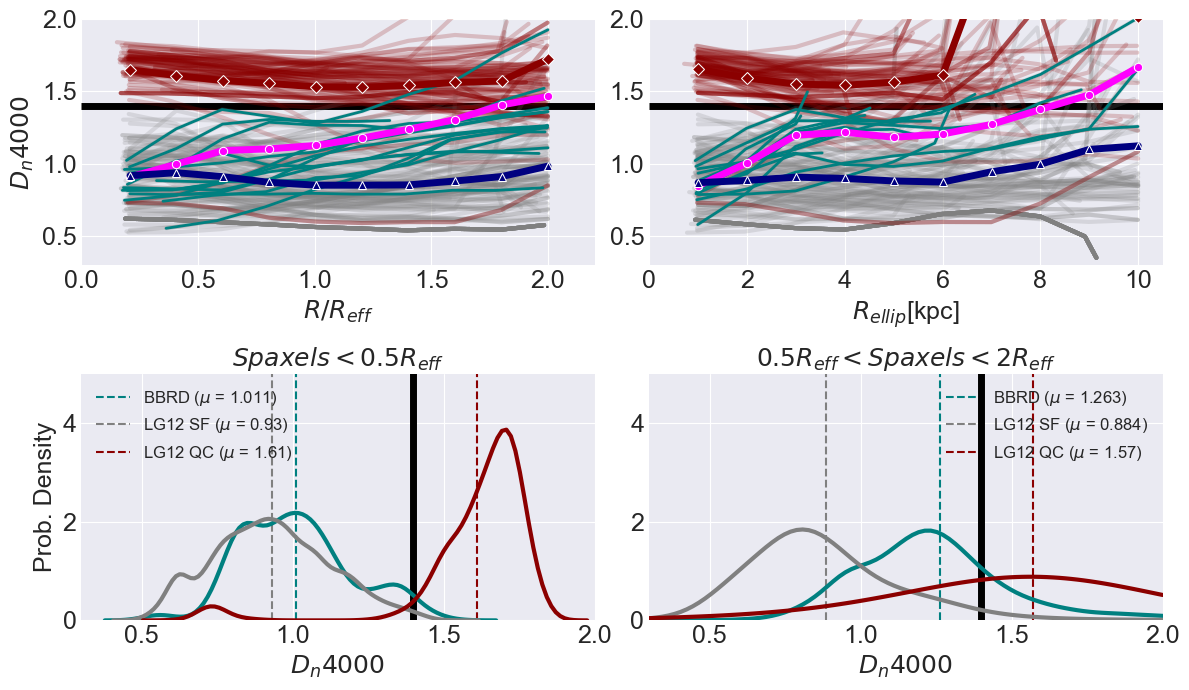

In [7]:
# # Set paths for csv and supercsv
# super_csv_dir_path = ''
# bbrd_csv_maps_path = '/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/'
# lg12_csv_maps_path = '/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/'

# # Test function

radpro_dist_subplots(bbrd_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv'), 
    lg12_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv'),
    bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv'),
    lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv'),
    lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv'),
    ydata_str = 'DAP_DN4000',
    yerr_str = 'DAP_DN4000_IVAR',
    reff_bins = np.linspace(0.01, 2.0, 11),
    rellip_bins = np.linspace(0, 10, 11),
    cen_min = 0.0,
    cen_max = 0.5,
    out_min = 0.51,
    out_max = 2.0,
    x_reff_str='R/REFF', 
    x_rellip_str='R_KPC', 
    show_corot=False, 
    co_plateifu_list=['8254-1902', '10001-3702', '11760-1902', '11758-1901', '9183-3703'],
    bbrd_radpro_color = 'teal',
    lg12_sf_radpro_color = 'grey',
    lg12_qc_radpro_color = 'darkred',
    reff_xlim = (0.0, 2.2),
    rellip_xlim = (0. , 10.5),
    ydata_lim = (0.3, 2.0),
    reff_label = r'$R/R_{eff}$',
    ydata_label = r'$D_{n}4000$',
    bbrd_fw_avg_color = 'magenta',
    lg12_sf_fw_avg_color = 'navy',
    lg12_qc_fw_avg_color = 'darkred',
    co_rot_color = 'orange',
    kde_prod_den_lim = (0.0, 5.0),
    dist_bins = 20,
    kde_clip_lim = (0.0, 2.0),
    saveplot_filepath = '/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_lg12_bbrd_dn4000sub.pdf'
    )

# **<span style='color:Green'> Luminosity Weighted Age </span>**
***

In [8]:
bbrd_sf_super_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'HALPHA', 'HALPHA KCORR', 'HBETA KCORR',
       'NII6585 KCORR', 'OII3727 KCORR', 'OII3729 KCORR', 'OIII5008 KCORR',
       'SII6718 KCORR', 'SII6732 KCORR', 'HALPHA SNR', 'HBETA SNR',
       'NII6585 SNR', 'OII3727 SNR', 'OII3729 SNR', 'OIII5008 SNR',
       'SII6718 SNR', 'SII6732 SNR', 'HALPHA ERROR', 'HBETA ERROR',
       'NII6585 ERROR', 'OII3727 ERROR', 'OII3729 ERROR', 'OIII5008 ERROR',
       'SII6718 ERROR', 'SII6732 ERROR', 'HALPHA_DQ', 'HA/HB', 'HA LUM',
       'LOGSFR', 'LOGSFR DENSITY', 'ELLIP R', 'R/REFF', 'LOG(O/H)+12_[N2O2]',
       'LOG(O/H)+12_[O3N2]', 'LOG(O/H)+12_[N2]', 'GYR_LW', 'GYR_MW', 'GYR_ERR',
       'SP_ZSUBL', 'SP_ZSUBM', 'SP_ZERR', 'VEL_KM/S', 'VEL_ERR]', 'VDISP_KM/S',
       'VDISP_ERR', 'M/L', 'MSUN/SPX2', 'MSUN/ARCS2', 'MSUN_ERR', 'D4000',
       'D4000_ERR', 'HDELTA', 'HDELTA_ERR', 'O3HB_RATIO', 'N2HA_RATIO',
       'BPT_CLASS', 'B20_DELTASFR', 'B20_SFRD', 'B20_SFRD_UPLIM',
       'B20_SFRD_LOWLIM', 'DAP_D4000', 'DA

In [9]:
bbrd_sf_super_df[['GYR_LW', 'GYR_MW', 'GYR_ERR']].describe()

,GYR_LW,GYR_MW,GYR_ERR
count,26744.000000,26744.000000,26744.000000
mean,5.231047,5.469621,0.042600
std,4.579810,4.784752,0.186951
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,8.914673,9.449051,0.000000
75%,9.339087,9.679687,0.075291
max,10.010724,10.127620,22.444180


Plotting SF LG12 sample
Plotting QC LG12 sample
Plotting SF BBRD sample


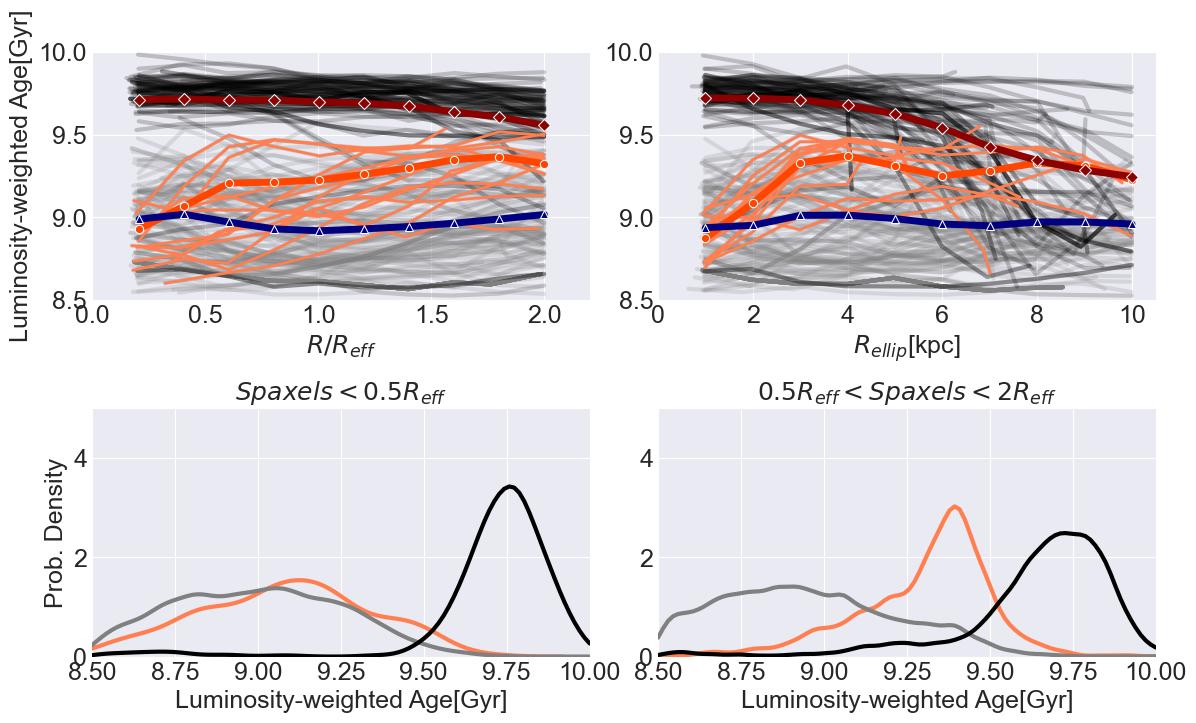

In [13]:
radpro_dist_subplots(bbrd_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv'), 
    lg12_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv'),
    bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv'),
    lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv'),
    lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv'),
    ydata_str = 'GYR_LW',
    yerr_str = 'GYR_ERR',
    reff_bins = np.linspace(0.01, 2.0, 11),
    rellip_bins = np.linspace(0, 10, 11),
    cen_min = 0.0,
    cen_max = 0.5,
    out_min = 0.51,
    out_max = 2.0,
    x_reff_str='R/REFF', 
    x_rellip_str='R_KPC', 
    show_corot=False, 
    co_plateifu_list=['8254-1902', '10001-3702', '11760-1902', '11758-1901', '9183-3703'],
    bbrd_radpro_color = 'coral',
    lg12_sf_radpro_color = 'grey',
    lg12_qc_radpro_color = 'black',
    reff_xlim = (0.0, 2.2),
    rellip_xlim = (0. , 10.5),
    ydata_lim = (8.5, 10),
    reff_label = r'$R/R_{eff}$',
    ydata_label = 'Luminosity-weighted Age[Gyr]',
    bbrd_fw_avg_color = 'orangered',
    lg12_sf_fw_avg_color = 'navy',
    lg12_qc_fw_avg_color = 'darkred',
    co_rot_color = 'orange',
    kde_prod_den_lim = (0.0, 5.0),
    dist_bins = 20,
    kde_clip_lim = (8.5, 10),
    saveplot_filepath = '/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_lg12_bbrd_Agesub.pdf'
    )

# **<span style='color:Lime'> sSFR[-yr] radial profile </span>**

In [ ]:
radpro_dist_subplots(bbrd_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv'), 
    lg12_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv'),
    bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv'),
    lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv'),
    lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv'),
    ydata_str = 'GYR_LW',
    yerr_str = 'GYR_ERR',
    reff_bins = np.linspace(0.01, 2.0, 11),
    rellip_bins = np.linspace(0, 10, 11),
    cen_min = 0.0,
    cen_max = 0.5,
    out_min = 0.51,
    out_max = 2.0,
    x_reff_str='R/REFF', 
    x_rellip_str='R_KPC', 
    show_corot=False, 
    co_plateifu_list=['8254-1902', '10001-3702', '11760-1902', '11758-1901', '9183-3703'],
    bbrd_radpro_color = 'coral',
    lg12_sf_radpro_color = 'grey',
    lg12_qc_radpro_color = 'black',
    reff_xlim = (0.0, 2.2),
    rellip_xlim = (0. , 10.5),
    ydata_lim = (8.5, 10),
    reff_label = r'$R/R_{eff}$',
    ydata_label = 'Luminosity-weighted Age[Gyr]',
    bbrd_fw_avg_color = 'orangered',
    lg12_sf_fw_avg_color = 'navy',
    lg12_qc_fw_avg_color = 'darkred',
    co_rot_color = 'orange',
    kde_prod_den_lim = (0.0, 5.0),
    dist_bins = 20,
    kde_clip_lim = (8.5, 10),
    saveplot_filepath = '/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_lg12_bbrd_Agesub.pdf'
    )

# **<span style='color:Yellow'> ======================================================== </span>**
*** 

# **<span style='color:Yellow'> Gas Velocity despersion </span>**

In [ ]:
lg12_sf_super_df['GASVEL_DISP'].describe()

Plotting SF LG12 sample
Plotting QC LG12 sample
Plotting SF BBRD sample
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators


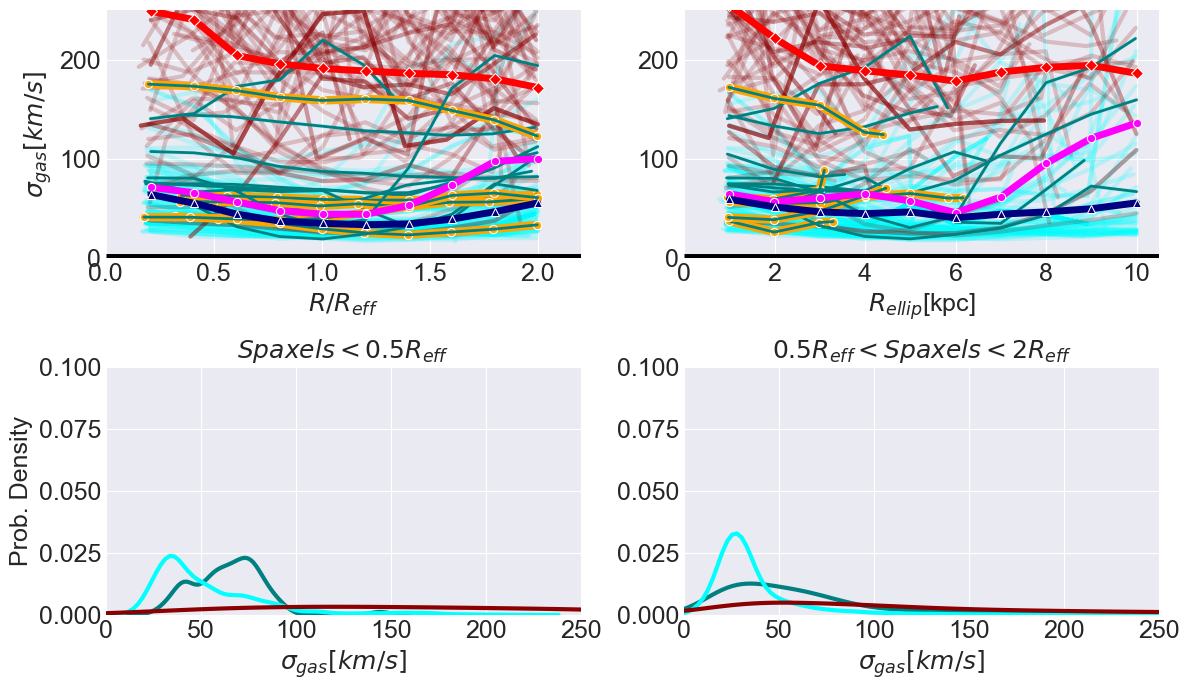

In [20]:
radpro_dist_subplots(bbrd_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv'), 
    lg12_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv'),
    bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv'),
    lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv'),
    lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv'),
    ydata_str = 'GASVEL_DISP',
    yerr_str = 'GASVEL_ERR_DISP',
    reff_bins = np.linspace(0.01, 2.0, 11),
    rellip_bins = np.linspace(0, 10, 11),
    cen_min = 0.0,
    cen_max = 0.5,
    out_min = 0.51,
    out_max = 2.0,
    x_reff_str='R/REFF', 
    x_rellip_str='R_KPC', 
    show_corot=True, 
    co_plateifu_list=['8254-1902', '10001-3702', '11760-1902', '11758-1901', '9183-3703'],
    bbrd_radpro_color = 'teal',
    lg12_sf_radpro_color = 'cyan',
    lg12_qc_radpro_color = 'darkred',
    reff_xlim = (0.0, 2.2),
    rellip_xlim = (0.0 , 10.5),
    ydata_lim = (0, 250),
    reff_label = r'$R/R_{eff}$',
    ydata_label = r'$\sigma_{gas}[km/s]$',
    bbrd_fw_avg_color = 'magenta',
    lg12_sf_fw_avg_color = 'navy',
    lg12_qc_fw_avg_color = 'red',
    kde_prod_den_lim = (0.0, 0.1),
    dist_bins = None,
    kde_clip_lim = (0.0, 250),
    saveplot_filepath = '/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_bbrd_lg12__vdispgas_sub.pdf'
    )

# **<span style='color:Yellow'> Stellar Velocity despersion </span>**

In [ ]:
bbrd_sf_super_df[['STARVEL_DISP1', 'STARVEL_DISPERR', 'STARVEL_DISP2']].describe()

Plotting SF LG12 sample
Plotting QC LG12 sample
Plotting SF BBRD sample
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators
Plotting co-rotators


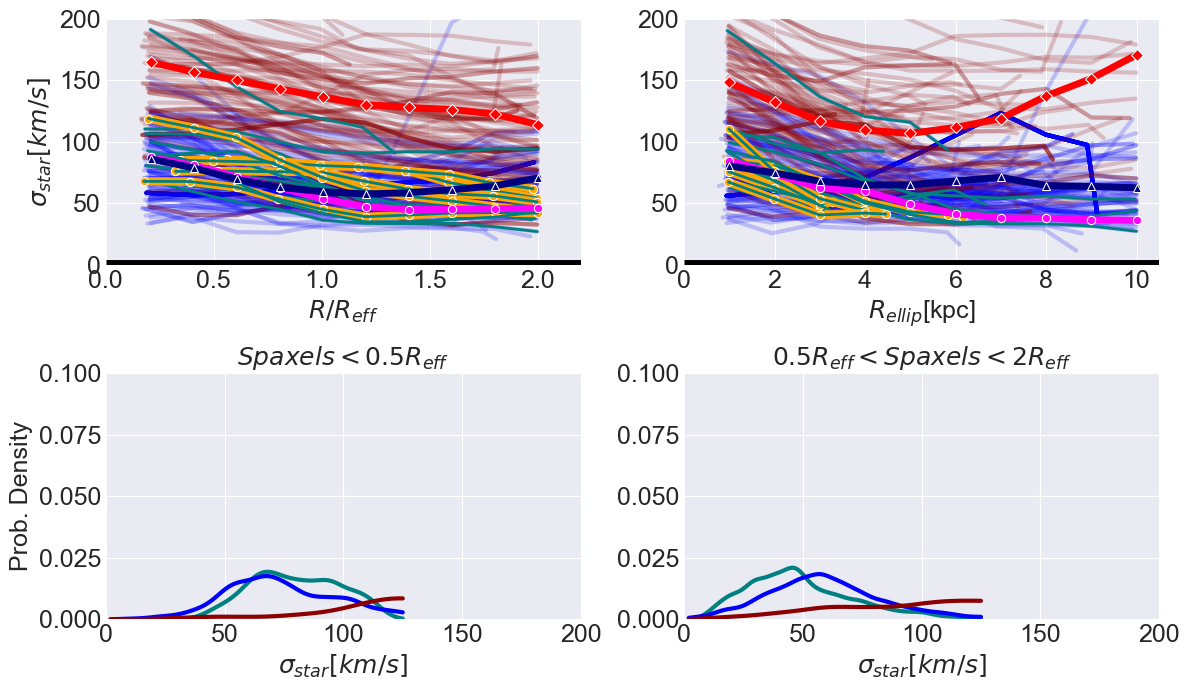

In [21]:
radpro_dist_subplots(bbrd_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv'), 
    lg12_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv'),
    bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv'),
    lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv'),
    lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv'),
    ydata_str = 'STARVEL_DISP2',
    yerr_str = 'STARVEL_DISPERR',
    reff_bins = np.linspace(0.01, 2.0, 11),
    rellip_bins = np.linspace(0, 10, 11),
    cen_min = 0.0,
    cen_max = 0.5,
    out_min = 0.51,
    out_max = 2.0,
    x_reff_str='R/REFF', 
    x_rellip_str='R_KPC', 
    show_corot=True, 
    co_plateifu_list=['8254-1902', '10001-3702', '11760-1902', '11758-1901', '9183-3703'],
    bbrd_radpro_color = 'teal',
    lg12_sf_radpro_color = 'blue',
    lg12_qc_radpro_color = 'darkred',
    reff_xlim = (0.0, 2.2),
    rellip_xlim = (0.0 , 10.5),
    ydata_lim = (0, 200),
    reff_label = r'$R/R_{eff}$',
    ydata_label = r'$\sigma_{star}[km/s]$',
    bbrd_fw_avg_color = 'magenta',
    lg12_sf_fw_avg_color = 'navy',
    lg12_qc_fw_avg_color = 'red',
    kde_prod_den_lim = (0.0, 0.1),
    dist_bins = 10,
    kde_clip_lim = (2, 125),
    saveplot_filepath = '/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_bbrd_lg12__vdispstar_sub.pdf'
    )

# **<span style='color:Yellow'> ---------------------------------------------------------------- </span>**

In [ ]:
# bbrd_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/*map.csv'), 
# lg12_csv_list=glob.glob('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/*map.csv'),
# bbrd_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_bbrd_ifu_super.csv'),
# lg12_sf_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/sf_dn4000_lg12_df.csv'),
# lg12_qc_super_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/supercsv_ifu_df/qc_dn4000_lg12_df.csv'),
# ydata_str = 'GASVEL_DISP',
# yerr_str = 'GASVEL_ERR_DISP',
# reff_bins = np.linspace(0.01, 2.0, 11),
# rellip_bins = np.linspace(0, 10, 11),
# cen_min = 0.0,
# cen_max = 0.5,
# out_min = 0.51,
# out_max = 2.0,
# x_reff_str='R/REFF', 
# x_rellip_str='R_KPC', 
# show_corot=True, 
# co_plateifu_list=['8254-1902', '10001-3702', '11760-1902', '11758-1901', '9183-3703'],
# bbrd_radpro_color = 'teal',
# lg12_sf_radpro_color = 'cyan',
# lg12_qc_radpro_color = 'darkred',
# reff_xlim = (0.0, 2.2),
# rellip_xlim = (0.0 , 10.5),
# ydata_lim = (0, 800),
# reff_label = r'$R/R_{eff}$',
# ydata_label = r'$\sigma_{gas}[km/s]$',
# bbrd_fw_avg_color = 'magenta',
# lg12_sf_fw_avg_color = 'navy',
# lg12_qc_fw_avg_color = 'red',
# kde_prod_den_lim = (0.0, 0.1),
# dist_bins = 100,
# kde_clip_lim = (0.0, 800)


# # BBRD complete smaple DN4000 weighted Average radial profile (reff)
# bbrd_sf_xdata_bin_spax, bbrd_sf_ydata_w_avgs, bbrd_sf_weight_df, bbrd_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=bbrd_csv_list)

# # Apply REFF radial binning function to super_csv files
# bbrd_sf_xdata0, bbrd_sf_ydata0, bbrd_sf_ydata0_err, bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, bbrd_sf_ydata0_err_binned_mean, bbrd_sf_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# # Apply RELLIP radial binning function to super_csv files
# bbrd_sf_rellip_xdata0, bbrd_sf_rellip_ydata0, bbrd_sf_rellip_ydata0_err, bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, bbrd_sf_rellip_ydata0_err_binned_mean, bbrd_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# bbrd_sf_central_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
# bbrd_sf_outer_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
# bbrd_sf_central_mean = np.mean(bbrd_sf_central_spax_df[ydata_str])
# bbrd_sf_outer_mean = np.mean(bbrd_sf_outer_spax_df[ydata_str])

# ################################ SF sample

# # LG12 complete smaple DN4000 weighted Average radial profile (reff)
# lg12_sf_xdata_bin_spax, lg12_sf_ydata_w_avgs, lg12_sf_weight_df, lg12_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)


# # Apply REFF radial binning function to super_csv files
# lg12_sf_xdata0, lg12_sf_ydata0, lg12_sf_ydata0_err, lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, lg12_sf_ydata0_err_binned_mean, lg12_sf_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 

# # Apply RELLIP radial binning function to super_csv files
# lg12_sf_rellip_xdata0, lg12_sf_rellip_ydata0, lg12_sf_rellip_ydata0_err, lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, lg12_sf_rellip_ydata0_err_binned_mean, lg12_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# lg12_sf_central_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
# lg12_sf_outer_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
# lg12_sf_central_mean = np.mean(lg12_sf_central_spax_df[ydata_str])
# lg12_sf_outer_mean = np.mean(lg12_sf_outer_spax_df[ydata_str])


# ################################ QC sample 
# # BBRD complete smaple DN4000 weighted Average radial profile (reff)
# lg12_qc_xdata_bin_spax, lg12_qc_ydata_w_avgs, lg12_qc_weight_df, lg12_qc_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)

# # Apply REFF radial binning function to super_csv files
# lg12_qc_xdata0, lg12_qc_ydata0, lg12_qc_ydata0_err, lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, lg12_qc_ydata0_err_binned_mean, lg12_qc_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# # Apply RELLIP radial binning function to super_csv files
# lg12_qc_rellip_xdata0, lg12_qc_rellip_ydata0, lg12_qc_rellip_ydata0_err, lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, lg12_qc_rellip_ydata0_err_binned_mean, lg12_qc_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# lg12_qc_central_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=cen_min, max=cen_max)
# lg12_qc_outer_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=out_min, max=out_max)
# lg12_qc_central_mean = np.mean(lg12_qc_central_spax_df[ydata_str])
# lg12_qc_outer_mean = np.mean(lg12_qc_outer_spax_df[ydata_str])


# ##############################################################################################################################################################################
# # Subplot
# fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(12,7), constrained_layout=False, dpi=100, sharey=False)

# # SF galaxies using fiber Dn4000 < 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# sf_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/sf_lg12_global_df.csv')
# for lg12_sf_plateifu in sf_lg12_merged_df['plateifu']:
#     lg12_sf_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_sf_plateifu))
#     sf_lg12_copy_df = lg12_sf_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=lg12_sf_radpro_color, alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_sf_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins)
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=lg12_sf_radpro_color, alpha=0.2, legend=False, linewidth=3)

# # QC galaxies using fiber Dn4000 > 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# qc_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/qc_lg12_global_df.csv')
# for lg12_qc_plateifu in qc_lg12_merged_df['plateifu']:
#     lg12_qc_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_qc_plateifu))
#     qc_lg12_copy_df = lg12_qc_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=lg12_qc_radpro_color, alpha=0.2, legend=False, linewidth=3, label='LG12 QC {}'.format(len(lg12_qc_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=lg12_qc_radpro_color, alpha=0.2, legend=False, linewidth=3)

# # Plot all BBRD csv list
# for bbrd_csv in bbrd_csv_list:
#     # Remove AGN and Merger galaxies 
#     # if (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
#     #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11827-1902_map.csv"
#     #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8595-3703_map.csv"
#     #     ):
#     #     pass
    
#     # highlight co-rotators
#     if show_corot==True:
#         for co_plateifu in co_plateifu_list:
#             if bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/{}_map.csv".format(co_plateifu):
#                 bbrd_df = pd.read_csv(bbrd_csv)
#                 bbrd_copy_df = bbrd_df.copy()
#                 xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#                 sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, marker="o", color='orange', alpha=1, legend=False, linewidth=2)
#                 xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#                 sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, marker="o", color='orange', alpha=1, legend=False, linewidth=2)
#             else:
#                 pass
#     else:
#         pass
#     # print(bbrd_csv)
#     bbrd_df = pd.read_csv(bbrd_csv)
#     bbrd_copy_df = bbrd_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color=bbrd_radpro_color, alpha=1, legend=False, linewidth=2)
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color=bbrd_radpro_color, alpha=1, legend=False, linewidth=2)

# # Plot frequency weighted median
# sns.lineplot(bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, ax=ax0, marker="o", color=bbrd_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
# sns.lineplot(lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, ax=ax0, marker="^", color=lg12_sf_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
# sns.lineplot(lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, ax=ax0, marker="D", color=lg12_qc_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample


# # sns.kdeplot(bbrd_sf_xdata0, bbrd_sf_ydata0, shade=True, shade_lowest=False, ax=ax0, color=bbrd_radpro_color, label='(#{}) BreakBRD spaxels'.format(len(bbrd_sf_ydata0)), levels=30)
# ax0.hlines(1.4, 0, 3, color='black', linewidth=5, linestyles='-')
# ax0.grid(True)
# ax0.set_xlim(reff_xlim)
# ax0.set_ylim(ydata_lim)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(reff_label, fontsize=18)
# ax0.set_ylabel(ydata_label, fontsize=18)
# # ax0.legend(ncol=1, fontsize=12, loc='lower left')




# # Ax1
# # Plot frequency weighted median
# sns.lineplot(bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, ax=ax1, marker="o", color=bbrd_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
# sns.lineplot(lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, ax=ax1, marker="^", color=lg12_sf_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
# sns.lineplot(lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, ax=ax1, marker="D", color=lg12_qc_fw_avg_color, alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

# ax1.hlines(1.4, 0, 15, color='black', linewidth=5, linestyles='-')
# ax1.grid(True)
# ax1.set_xlim(rellip_xlim)
# ax1.set_ylim(ydata_lim)
# ax1.set_xlabel(rellp_label, fontsize=18)
# ax1.tick_params(axis='x', labelsize=18)
# ax1.tick_params(axis='y', labelsize=18)


# # AX2
# # BBRD SF sample
# # sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, hist=False, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# # sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, hist=False, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": bbrd_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)

# # LG12 SF
# sns.distplot(lg12_sf_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": lg12_sf_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)

# # LG12 QC
# sns.distplot(lg12_qc_central_spax_df[ydata_str], bins=dist_bins, ax=ax2, kde=True, kde_kws={"color": lg12_qc_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False,)



# ax2.grid(True)
# ax2.set_xlim(ydata_lim)
# ax2.set_ylim(kde_prod_den_lim)
# ax2.set_xlabel(ydata_label, fontsize=18)
# ax2.set_ylabel('Prob. Density', fontsize=18)
# ax2.set_title(r'$Spaxels < 0.5 R_{eff}$', fontsize=18)
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)
# ax2.legend(fontsize=12, ncol=1)


# # Ax3 outer spaxel dist
# # bbrd sf
# sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": bbrd_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)

# # lg12 sf
# sns.distplot(lg12_sf_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": lg12_sf_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)

# # lg12 qc
# sns.distplot(lg12_qc_outer_spax_df[ydata_str], bins=dist_bins, ax=ax3, kde=True, kde_kws={"color": lg12_qc_radpro_color, "lw": 3, "alpha":1.0, 'clip': (kde_clip_lim)}, hist=False, vertical=False)


# ax3.grid(True)
# ax3.set_xlim(ydata_lim)
# ax3.set_ylim(kde_prod_den_lim)
# ax3.set_xlabel(ydata_label, fontsize=18)
# ax3.set_title(r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$', fontsize=18)
# ax3.tick_params(axis='x', labelsize=18)
# ax3.tick_params(axis='y', labelsize=18)
# ax3.legend(fontsize=12, loc='upper right', ncol=1)



# #VERTICAL LINES
# if ydata_str == 'DAP_DN4000':
#     ax2.vlines(np.mean(bbrd_sf_central_spax_df[ydata_str]), 0, 5.0, color=bbrd_radpro_color, alpha=1.0, linestyle='--', label=r'BBRD ($\mu$ = {})'.format(round(bbrd_sf_central_mean, 3)))
#     ax2.vlines(np.mean(lg12_sf_central_spax_df[ydata_str]), 0, 5.0, color=lg12_sf_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_central_mean, 3)))
#     ax2.vlines(np.mean(lg12_qc_central_spax_df[ydata_str]), 0, 5.0, color=lg12_qc_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_central_mean, 3)))
#     ax3.vlines(np.mean(bbrd_sf_outer_spax_df[ydata_str]), 0, 5.0, color=bbrd_radpro_color, alpha=1.0, linestyle='--', label=r'BBRD ($\mu$ = {})'.format(round(bbrd_sf_outer_mean, 3)))
#     ax3.vlines(np.mean(lg12_sf_outer_spax_df[ydata_str]), 0, 5.0, color=lg12_sf_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_outer_mean, 3)))
#     ax3.vlines(np.mean(lg12_qc_outer_spax_df[ydata_str]), 0, 5.0, color=lg12_qc_radpro_color, alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_outer_mean, 3)))
#     ax3.vlines(1.4, 0, 8, color='black', linewidth=5)
#     ax2.vlines(1.4, 0, 8, color='black', linewidth=5)
#     ax3.vlines(1.4, 0, 8, color='black', linewidth=5)

# else:
#     pass

# plt.tight_layout()
# # plt.savefig('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_bbrd_lg12_subplot.pdf', dpi=300)


<!-- # **<span style='color:Pink'> LG12 Dn4000 radial profiles </span>** -->
<!-- ***  -->

In [ ]:
# # Assign the x and y variables with the series column name as a str
# x_reff_str = 'R/REFF'
# x_rellip_str = 'R_KPC'
# ydata_str = 'DAP_DN4000'
# yerr_str = 'DAP_DN4000_IVAR'
# reff_bins = np.linspace(0.01, 2.2, 11)
# rellip_bins = np.linspace(0, 10, 11)

# # BBRD complete smaple DN4000 weighted Average radial profile (reff)
# bbrd_sf_xdata_bin_spax, bbrd_sf_ydata_w_avgs, bbrd_sf_weight_df, bbrd_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=bbrd_csv_list)

# # Apply REFF radial binning function to super_csv files
# bbrd_sf_xdata0, bbrd_sf_ydata0, bbrd_sf_ydata0_err, bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, bbrd_sf_ydata0_err_binned_mean, bbrd_sf_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# # Apply RELLIP radial binning function to super_csv files
# bbrd_sf_rellip_xdata0, bbrd_sf_rellip_ydata0, bbrd_sf_rellip_ydata0_err, bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, bbrd_sf_rellip_ydata0_err_binned_mean, bbrd_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# bbrd_sf_central_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# bbrd_sf_outer_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# bbrd_sf_central_mean = np.mean(bbrd_sf_central_spax_df[ydata_str])
# bbrd_sf_outer_mean = np.mean(bbrd_sf_outer_spax_df[ydata_str])



# ################################ SF sample

# # LG12 complete smaple DN4000 weighted Average radial profile (reff)
# lg12_sf_xdata_bin_spax, lg12_sf_ydata_w_avgs, lg12_sf_weight_df, lg12_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)


# # Apply REFF radial binning function to super_csv files
# lg12_sf_xdata0, lg12_sf_ydata0, lg12_sf_ydata0_err, lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, lg12_sf_ydata0_err_binned_mean, lg12_sf_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 

# # Apply RELLIP radial binning function to super_csv files
# lg12_sf_rellip_xdata0, lg12_sf_rellip_ydata0, lg12_sf_rellip_ydata0_err, lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, lg12_sf_rellip_ydata0_err_binned_mean, lg12_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# lg12_sf_central_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# lg12_sf_outer_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# lg12_sf_central_mean = np.mean(lg12_sf_central_spax_df[ydata_str])
# lg12_sf_outer_mean = np.mean(lg12_sf_outer_spax_df[ydata_str])


# ################################ QC sample 
# # BBRD complete smaple DN4000 weighted Average radial profile (reff)
# lg12_qc_xdata_bin_spax, lg12_qc_ydata_w_avgs, lg12_qc_weight_df, lg12_qc_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)

# # Apply REFF radial binning function to super_csv files
# lg12_qc_xdata0, lg12_qc_ydata0, lg12_qc_ydata0_err, lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, lg12_qc_ydata0_err_binned_mean, lg12_qc_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# # Apply RELLIP radial binning function to super_csv files
# lg12_qc_rellip_xdata0, lg12_qc_rellip_ydata0, lg12_qc_rellip_ydata0_err, lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, lg12_qc_rellip_ydata0_err_binned_mean, lg12_qc_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# lg12_qc_central_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# lg12_qc_outer_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# lg12_qc_central_mean = np.mean(lg12_qc_central_spax_df[ydata_str])
# lg12_qc_outer_mean = np.mean(lg12_qc_outer_spax_df[ydata_str])






In [ ]:
# ############################################################################################################################

# # Subplot
# fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(12,7), constrained_layout=True, dpi=100, sharey=False, facecolor='lightgrey')
# show_corot = False

# # SF galaxies using fiber Dn4000 < 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# sf_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/sf_lg12_global_df.csv')
# for lg12_sf_plateifu in sf_lg12_merged_df['plateifu']:
#     lg12_sf_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_sf_plateifu))
#     sf_lg12_copy_df = lg12_sf_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_sf_df)))
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_sf_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3)

# # SF galaxies using fiber Dn4000 < 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# qc_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/qc_lg12_global_df.csv')
# for lg12_qc_plateifu in qc_lg12_merged_df['plateifu']:
#     lg12_qc_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_qc_plateifu))
#     qc_lg12_copy_df = lg12_qc_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='darkred', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_qc_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='darkred', alpha=0.2, legend=False, linewidth=3)



# # Plot all csv list
# for bbrd_csv in bbrd_csv_list:
#     # Remove AGN and Merger galaxies 
#     if (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11827-1902_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8595-3703_map.csv"
#         ):
#         pass




#     # highlight co-rotators
#     if show_corot==True and (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8254-1902_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/10001-3702_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11760-1902_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11758-1901_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
#         ):

#         bbrd_df = pd.read_csv(bbrd_csv)
#         bbrd_copy_df = bbrd_df.copy()
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, marker="o", color='orange', alpha=1, legend=False, linewidth=2)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, marker="o", color='orange', alpha=1, legend=False, linewidth=2)

#     else:
#         # print(bbrd_csv)
#         bbrd_df = pd.read_csv(bbrd_csv)
#         bbrd_copy_df = bbrd_df.copy()
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='teal', alpha=1, legend=False, linewidth=2)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='teal', alpha=1, legend=False, linewidth=2)


# # Plot frequency weighted median
# sns.lineplot(bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, ax=ax0, marker="o", color='black', alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
# sns.lineplot(lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, ax=ax0, marker="^", color='midnightblue', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
# sns.lineplot(lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, ax=ax0, marker="D", color='red', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

# # sns.kdeplot(bbrd_sf_xdata0, bbrd_sf_ydata0, shade=True, shade_lowest=False, ax=ax0, color='teal', label='(#{}) BreakBRD spaxels'.format(len(bbrd_sf_ydata0)), levels=30)
# ax0.hlines(1.4, 0, 3, color='black', linewidth=5, linestyles='-')
# ax0.grid(True)
# ax0.set_xlim(0.0, 2.5)
# ax0.set_ylim(0.3, 2.0)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
# ax0.set_ylabel(r'$D_{n}$4000', fontsize=18)
# # ax0.legend(ncol=1, fontsize=12, loc='lower left')




# # Ax1
# # Plot frequency weighted median
# sns.lineplot(bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, ax=ax1, marker="o", color='black', alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
# sns.lineplot(lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, ax=ax1, marker="^", color='midnightblue', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
# sns.lineplot(lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, ax=ax1, marker="D", color='red', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

# ax1.hlines(1.4, 0, 15, color='black', linewidth=5, linestyles='-')
# ax1.grid(True)
# ax1.set_xlim(0.0, 11)
# ax1.set_ylim(0.3, 2.0)
# ax1.set_xlabel(r'$R_{ellip}$[kpc]', fontsize=18)

# ax1.tick_params(axis='x', labelsize=18)
# ax1.tick_params(axis='y', labelsize=18)


# # AX2
# # BBRD SF sample
# # sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, hist=False, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# # sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=20, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, hist=False, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "teal", "lw": 3, "alpha":1.0}, hist=False, vertical=False,)
# ax2.vlines(np.mean(bbrd_sf_central_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'BBRD ($\mu$ = {})'.format(round(bbrd_sf_central_mean, 3)))

# # LG12 SF
# sns.distplot(lg12_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "navy", "lw": 3, "alpha":1.0}, hist=False, vertical=False,)
# ax2.vlines(np.mean(lg12_sf_central_spax_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_central_mean, 3)))

# # LG12 QC
# sns.distplot(lg12_qc_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "darkred", "lw": 3, "alpha":1.0}, hist=False, vertical=False,)
# ax2.vlines(np.mean(lg12_qc_central_spax_df[ydata_str]), 0, 2000, color='darkred', alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_central_mean, 3)))


# ax2.vlines(1.4, 0, 2000, color='black', linewidth=5)
# ax2.grid(True)
# ax2.set_xlim(0.0, 3)
# ax2.set_ylim(0.0, 5.0)
# ax2.set_xlabel(r'$D_{n}$4000', fontsize=18)
# ax2.set_ylabel('N', fontsize=18)
# ax2.set_title(r'$Spaxels < 0.5 R_{eff}$', fontsize=18)
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)
# ax2.legend(fontsize=8, ncol=1)
# # plt.tight_layout()

# # Ax3 outer spaxel dist
# # bbrd sf
# sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "teal", "lw": 3, "alpha":1.0, 'clip': (0.0, 3.0)}, hist=False, vertical=False)
# ax3.vlines(np.mean(bbrd_sf_outer_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'BBRD ($\mu$ = {})'.format(round(bbrd_sf_outer_mean, 3)))

# # lg12 sf
# sns.distplot(lg12_sf_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "navy", "lw": 3, "alpha":1.0, 'clip': (0.0, 3.0)}, hist=False, vertical=False)
# ax3.vlines(np.mean(lg12_sf_outer_spax_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'LG12 SF ($\mu$ = {})'.format(round(lg12_sf_outer_mean, 3)))

# # lg12 qc
# sns.distplot(lg12_qc_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "darkred", "lw": 3, "alpha":1.0, 'clip': (0.0, 3.0)}, hist=False, vertical=False)
# ax3.vlines(np.mean(lg12_qc_outer_spax_df[ydata_str]), 0, 2000, color='darkred', alpha=1.0, linestyle='--', label=r'LG12 QC ($\mu$ = {})'.format(round(lg12_qc_outer_mean, 3)))


# ax3.vlines(1.4, 0, 2000, color='black', linewidth=5)
# ax3.grid(True)
# ax3.set_xlim(0.0, 3)
# ax3.set_ylim(0.0, 5.0)
# ax3.set_xlabel(r'$D_{n}$4000', fontsize=18)
# ax3.set_title(r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$', fontsize=18)
# ax3.tick_params(axis='x', labelsize=18)
# ax3.tick_params(axis='y', labelsize=18)
# ax3.legend(fontsize=8, loc='upper right', ncol=1)


# plt.savefig('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/dn4000cut_bbrd_lg12_subplot.pdf', dpi=300)

# **<span style='color:Orange'> LG12 Age radial profiles </span>**
*** 

In [ ]:
# lg12_sf_super_df.columns

In [ ]:
# lg12_sf_super_df['GYR_LW'].describe()

In [ ]:
# # Assign the x and y variables with the series column name as a str
# x_reff_str = 'R/REFF'
# x_rellip_str = 'R_KPC'
# ydata_str = 'GYR_LW'
# yerr_str = 'GYR_ERR'
# reff_bins = np.linspace(0.01, 2.2, 11)
# rellip_bins = np.linspace(0, 10, 11)

# # BBRD complete smaple DN4000 weighted Average radial profile (reff)
# bbrd_sf_xdata_bin_spax, bbrd_sf_ydata_w_avgs, bbrd_sf_weight_df, bbrd_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=bbrd_csv_list)

# # Apply REFF radial binning function to super_csv files
# bbrd_sf_xdata0, bbrd_sf_ydata0, bbrd_sf_ydata0_err, bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, bbrd_sf_ydata0_err_binned_mean, bbrd_sf_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# # Apply RELLIP radial binning function to super_csv files
# bbrd_sf_rellip_xdata0, bbrd_sf_rellip_ydata0, bbrd_sf_rellip_ydata0_err, bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, bbrd_sf_rellip_ydata0_err_binned_mean, bbrd_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(bbrd_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# bbrd_sf_central_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# bbrd_sf_outer_spax_df = radial_intergration(df=bbrd_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# bbrd_sf_central_mean = np.mean(bbrd_sf_central_spax_df[ydata_str])
# bbrd_sf_outer_mean = np.mean(bbrd_sf_outer_spax_df[ydata_str])



# ################################ SF sample

# # LG12 complete smaple DN4000 weighted Average radial profile (reff)
# lg12_sf_xdata_bin_spax, lg12_sf_ydata_w_avgs, lg12_sf_weight_df, lg12_sf_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)


# # Apply REFF radial binning function to super_csv files
# lg12_sf_xdata0, lg12_sf_ydata0, lg12_sf_ydata0_err, lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, lg12_sf_ydata0_err_binned_mean, lg12_sf_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 

# # Apply RELLIP radial binning function to super_csv files
# lg12_sf_rellip_xdata0, lg12_sf_rellip_ydata0, lg12_sf_rellip_ydata0_err, lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, lg12_sf_rellip_ydata0_err_binned_mean, lg12_sf_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_sf_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# lg12_sf_central_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# lg12_sf_outer_spax_df = radial_intergration(df=lg12_sf_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# lg12_sf_central_mean = np.mean(lg12_sf_central_spax_df[ydata_str])
# lg12_sf_outer_mean = np.mean(lg12_sf_outer_spax_df[ydata_str])


# ################################ QC sample 
# # BBRD complete smaple DN4000 weighted Average radial profile (reff)
# lg12_qc_xdata_bin_spax, lg12_qc_ydata_w_avgs, lg12_qc_weight_df, lg12_qc_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)

# # Apply REFF radial binning function to super_csv files
# lg12_qc_xdata0, lg12_qc_ydata0, lg12_qc_ydata0_err, lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, lg12_qc_ydata0_err_binned_mean, lg12_qc_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
# # Apply RELLIP radial binning function to super_csv files
# lg12_qc_rellip_xdata0, lg12_qc_rellip_ydata0, lg12_qc_rellip_ydata0_err, lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, lg12_qc_rellip_ydata0_err_binned_mean, lg12_qc_rellip_super_nonan_df = df_reff_bin_mean_dist(lg12_qc_super_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 

# # Radial intergration
# lg12_qc_central_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# lg12_qc_outer_spax_df = radial_intergration(df=lg12_qc_super_nonan_df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# lg12_qc_central_mean = np.mean(lg12_qc_central_spax_df[ydata_str])
# lg12_qc_outer_mean = np.mean(lg12_qc_outer_spax_df[ydata_str])



In [ ]:
# # Subplot
# fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(12,7), constrained_layout=True, dpi=300, sharey=False)


# # SF galaxies using fiber Dn4000 < 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# sf_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/sf_lg12_global_df.csv')
# for lg12_sf_plateifu in sf_lg12_merged_df['plateifu']:
#     lg12_sf_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_sf_plateifu))
#     sf_lg12_copy_df = lg12_sf_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_sf_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='cornflowerblue', alpha=0.2, legend=False, linewidth=3)

# # SF galaxies using fiber Dn4000 < 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# qc_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000cut_sf_qc_superdf/qc_lg12_global_df.csv')
# for lg12_qc_plateifu in qc_lg12_merged_df['plateifu']:
#     lg12_qc_df = pd.read_csv('/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/lg12_MMfits/{}_map.csv'.format(lg12_qc_plateifu))
#     qc_lg12_copy_df = lg12_qc_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='darkred', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_qc_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='darkred', alpha=0.2, legend=False, linewidth=3)



# # Plot all csv list
# for bbrd_csv in bbrd_csv_list:
#     # Remove AGN and Merger galaxies 
#     # if (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
#     #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11827-1902_map.csv"
#     #     or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8595-3703_map.csv"
#     #     ):
#     #     pass
#     # highlight co-rotators
#     if (bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/8254-1902_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/10001-3702_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11760-1902_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/11758-1901_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/MM_manga_maps_FITS_CSV/bbrd_MMfits/9183-3703_map.csv"
#         ):
#         bbrd_df = pd.read_csv(bbrd_csv)
#         bbrd_copy_df = bbrd_df.copy()
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='orange', alpha=1, legend=False, linewidth=2)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='orange', alpha=1, legend=False, linewidth=2)

    
#     else:
#         # print(bbrd_csv)
#         bbrd_df = pd.read_csv(bbrd_csv)
#         bbrd_copy_df = bbrd_df.copy()
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='teal', alpha=1, legend=False, linewidth=2)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='teal', alpha=1, legend=False, linewidth=2)


# # Plot frequency weighted median
# sns.lineplot(bbrd_sf_xdata0_binned_mean, bbrd_sf_ydata0_binned_mean, ax=ax0, color='black', alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
# sns.lineplot(lg12_sf_xdata0_binned_mean, lg12_sf_ydata0_binned_mean, ax=ax0, color='midnightblue', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
# sns.lineplot(lg12_qc_xdata0_binned_mean, lg12_qc_ydata0_binned_mean, ax=ax0, color='red', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

# # sns.kdeplot(bbrd_sf_xdata0, bbrd_sf_ydata0, shade=True, shade_lowest=False, ax=ax0, color='teal', label='(#{}) BreakBRD spaxels'.format(len(bbrd_sf_ydata0)), levels=30)
# ax0.hlines(1.4, 0, 3, color='black', linewidth=5, linestyles='-')
# ax0.grid(True)
# ax0.set_xlim(0.0, 2.5)
# ax0.set_ylim(8.5, 10.0)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
# ax0.set_ylabel('Luminosity Weighted Age[Gyr]', fontsize=18)
# # ax0.legend(ncol=1, fontsize=12, loc='lower left')




# # Ax1
# # Plot frequency weighted median
# sns.lineplot(bbrd_sf_rellip_xdata0_binned_mean, bbrd_sf_rellip_ydata0_binned_mean, ax=ax1, color='black', alpha=1.0, legend=False, linewidth=5, markers='o') # BBRD SF sample
# sns.lineplot(lg12_sf_rellip_xdata0_binned_mean, lg12_sf_rellip_ydata0_binned_mean, ax=ax1, color='midnightblue', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 SF sample
# sns.lineplot(lg12_qc_rellip_xdata0_binned_mean, lg12_qc_rellip_ydata0_binned_mean, ax=ax1, color='red', alpha=1.0, legend=False, linewidth=5, markers='o') # LG12 QC sample

# ax1.hlines(1.4, 0, 15, color='black', linewidth=5, linestyles='-')
# ax1.grid(True)
# ax1.set_xlim(0.0, 11)
# ax1.set_ylim(8.5, 10.0)
# ax1.set_xlabel(r'$R_{ellip}$', fontsize=18)

# ax1.tick_params(axis='x', labelsize=18)
# ax1.tick_params(axis='y', labelsize=18)


# # AX2
# # BBRD SF sample
# # sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, hist=False, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# # sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=20, ax=ax2, kde=True, color='cyan', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, hist=False, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# sns.distplot(bbrd_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "teal", "lw": 3, "label": "KDE", "alpha":1.0}, hist=False, vertical=False, label=r'$Spaxels < 0.5 R_{eff}$')
# ax2.vlines(np.mean(bbrd_sf_central_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(bbrd_sf_central_mean, 3)))

# # LG12 SF
# sns.distplot(lg12_sf_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "navy", "lw": 3, "label": "KDE", "alpha":1.0}, hist=False, vertical=False, label=r'$Spaxels < 0.5 R_{eff}$')
# ax2.vlines(np.mean(lg12_sf_central_spax_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(lg12_sf_central_mean, 3)))

# # LG12 QC
# sns.distplot(lg12_qc_central_spax_df[ydata_str], bins=10, ax=ax2, kde=True, kde_kws={"color": "darkred", "lw": 3, "label": "KDE", "alpha":1.0}, hist=False, vertical=False, label=r'$Spaxels < 0.5 R_{eff}$')
# ax2.vlines(np.mean(lg12_qc_central_spax_df[ydata_str]), 0, 2000, color='darkred', alpha=1.0, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(lg12_qc_central_mean, 3)))


# ax2.vlines(1.4, 0, 2000, color='black', linewidth=5)
# ax2.grid(True)
# ax2.set_xlim(8.5, 10.0)
# ax2.set_ylim(0.0, 5.0)
# ax2.set_xlabel('Luminosity Weighted Age[Gyr]', fontsize=18)
# ax2.set_ylabel('N')
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)
# # ax2.legend(fontsize=8, loc='lower right', ncol=3)
# # plt.tight_layout()

# # Ax3 outer spaxel dist
# # bbrd sf
# sns.distplot(bbrd_sf_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "teal", "lw": 3, "alpha":1.0, 'clip': (8.5, 10.5)}, hist=False, vertical=False, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# ax3.vlines(np.mean(bbrd_sf_outer_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(bbrd_sf_outer_mean, 3)))

# # lg12 sf
# sns.distplot(lg12_sf_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "navy", "lw": 3, "alpha":1.0, 'clip': (8.5, 10.5)}, hist=False, vertical=False, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# ax3.vlines(np.mean(lg12_sf_outer_spax_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(lg12_sf_outer_mean, 3)))

# # lg12 qc
# sns.distplot(lg12_qc_outer_spax_df[ydata_str], bins=20, ax=ax3, kde=True, kde_kws={"color": "darkred", "lw": 3, "alpha":1.0, 'clip': (8.5, 10.5)}, hist=False, vertical=False, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# ax3.vlines(np.mean(lg12_qc_outer_spax_df[ydata_str]), 0, 2000, color='darkred', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(lg12_qc_outer_mean, 3)))


# ax3.vlines(1.4, 0, 2000, color='black', linewidth=5)
# ax3.grid(True)
# ax3.set_xlim(8.5, 10.0)
# ax3.set_ylim(0.0, 5.0)
# ax3.set_xlabel('Luminosity Weighted Age[Gyr]', fontsize=18)
# # ax3.set_ylabel('N')
# ax3.tick_params(axis='x', labelsize=18)
# ax3.tick_params(axis='y', labelsize=18)



# plt.savefig('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_Dn4000cut_sf_qc_superdf/dn4000cut_Age_bbrd_lg12_subplot.pdf')

In [ ]:
print(type(fig))
# ax1.hlines(9.5, xmin=8.5, xmax=11)
# plt.show()

# **<span style='color:Red'> ################################## </span>**


In [ ]:
# # Assign the x and y variables with the series column name as a str
# x_reff_str = 'R/REFF'
# x_rellip_str = 'R_KPC'
# ydata_str = 'DAP_DN4000'
# yerr_str = 'GYR_ERR'
# reff_bins = np.linspace(0.01, 2.2, 11)
# rellip_bins = np.linspace(0, 10, 11)

# # Run radial binning function to make median and mean radial profile
# xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(all_lg12_ifu_super_df_cp, x_reff_str, ydata_str, yerr_str, reff_bins)


# # Make central spaxels dataframe from Combo 
# central_spax_df = radial_intergration(df=df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# outer_spax_df = radial_intergration(df=df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# central_mean = np.mean(central_spax_df[ydata_str])
# outer_mean = np.mean(outer_spax_df[ydata_str])


# # LG12 complete smaple DN4000 weighted Average radial profile (reff)
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)


# # Subplot
# fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True, dpi=300, sharey=True)

# # AX0
# # sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax0, color='teal', label='(#{}) BreakBRD spaxels'.format(len(ydata0)), levels=30)
# # sns.scatterplot(xdata0, ydata0, ax=ax0, color='black')
# # sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax0, marker="o", color='palevioletred', alpha=1.0, label='Frequency-weighted Avg', linewidth=5)
# ax0.hlines(1.5, 0, 3, color='black', linewidth=5, linestyles='--')
# ax0.grid(True)
# ax0.set_xlim(0.0, 2.5)
# ax0.set_ylim(0.3, 2.0)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
# ax0.set_ylabel(r'$D_{n}$4000', fontsize=18)
# ax0.legend(ncol=1, fontsize=12, loc='lower left')


# #AX1
# # all_lg12_ifu_super_df_cp = all_lg12_ifu_super_df.copy()
# xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(all_lg12_ifu_super_df_cp, x_rellip_str, ydata_str, yerr_str, rellip_bins)

# # DN4000 weighted Average radial profile (reff)
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_rellip_str, ydata_str=ydata_str, bins=rellip_bins, csv_file_list=lg12_csv_list)

# # sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax1, color='teal', label=r'$D_{n}$4000 spaxels', legend=False, levels=15)
# # sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax1, marker="o", color='palevioletred', alpha=1.0, linewidth=5, legend=False)
# ax1.hlines(1.5, 0, 20, color='black', linewidth=5, linestyles='--') 
# ax1.grid(True)
# ax1.set_xlim(0, 12)
# # ax1.set_ylim(0.8, 1.6)
# ax1.tick_params(axis='x', labelsize=18)
# ax1.set_xlabel('R [kpc]', fontsize=18)


# # AX2
# sns.distplot(central_spax_df[ydata_str], bins=1000, ax=ax2, kde=False, color='teal', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# sns.distplot(outer_spax_df[ydata_str], bins=2000, ax=ax2, kde=False, color='teal', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# ax2.hlines(1.4, 0, 2000, color='black')
# ax2.hlines(np.mean(central_spax_df[ydata_str]), 0, 2000, color='teal', alpha=0.5, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(central_mean, 3)))
# ax2.hlines(np.mean(outer_spax_df[ydata_str]), 0, 2000, color='teal', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(outer_mean, 3)))
# ax2.grid(True)
# ax2.set_xlabel('N', fontsize=18)
# ax2.set_ylabel(' ')
# ax2.tick_params(axis='x', labelsize=18)
# ax2.legend(fontsize=14, loc='lower right')
# plt.tight_layout()

# # # Interate through all lg12 dataframes and plots indivdual the profiles in subplots
# # for lg12_csv in glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv"):

#         # # print(lg12_csv)
#         # lg12_df = pd.read_csv(lg12_csv)
#         # lg12_copy_df = lg12_df.copy()
#         # # all_lg12_ifu_super_df_cp.dropna(subset=[ydata_str, 'DAP_D4000', 'D4000', yerr_str, 'DAP_D4000_IVAR', 'D4000_ERR', x_rellip_str, x_reff_str,'R_KPC'], inplace=True)
#         # xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         # sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='palevioletred', alpha=0.2, legend=False, linewidth=3)
#         # # sns.scatterplot(xdata0, ydata0, ax=ax0)
#         # xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         # sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='palevioletred', alpha=0.2, legend=False, linewidth=3)

# # SF galaxies using fiber Dn4000 < 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# sf_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000_sf_qc_dfs/sf_lg12_merged_df.csv')
# for lg12_sf_plateifu in sf_lg12_merged_df['plateifu']:
#     lg12_sf_df = pd.read_csv('/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/{}_map.csv'.format(lg12_sf_plateifu))
#     sf_lg12_copy_df = lg12_sf_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='navy', alpha=0.2, legend=False, linewidth=3, label='LG12 SF {}'.format(len(lg12_sf_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(sf_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='navy', alpha=0.2, legend=False, linewidth=3)


# # QC galaxies using fiber Dn4000 > 1.5
# # # Interate through SF LG12 dataframes and plots indivdual the profiles in subplots
# qc_lg12_merged_df = pd.read_csv('/Users/mmckay/Desktop/research/BreakBRD_LG12_analysis_repo/lg12_dn4000_sf_qc_dfs/qc_lg12_merged_df.csv')
# for lg12_qc_plateifu in qc_lg12_merged_df['plateifu']:
#     lg12_qc_df = pd.read_csv('/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/{}_map.csv'.format(lg12_qc_plateifu))
#     qc_lg12_copy_df = lg12_qc_df.copy()
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='darkred', alpha=0.2, legend=False, linewidth=3, label='LG12 QC {}'.format(len(lg12_qc_df)))
#     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(qc_lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='darkred', alpha=0.2, legend=False, linewidth=3)

# # BBRD SF sample
# for bbrd_csv in glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/*_map.csv"):
#     # Remove the merger and AGN galaxy from the Combo csv file and adds AGn to there own csv 
#     if (bbrd_csv == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/9183-3703_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/11827-1902_map.csv"
#         or bbrd_csv == "/Users/mmckay/Desktop/research/FMR_MZR/bbrd_MMfits/8595-3703_map.csv"
#         ):
#         pass

#     else:
#         # print(bbrd_csv)
#         bbrd_df = pd.read_csv(bbrd_csv)
#         bbrd_copy_df = bbrd_df.copy()
#         # bbrd_combo_cp_df.dropna(subset=[ydata_str, 'DAP_D4000', 'D4000', yerr_str, 'DAP_D4000_IVAR', 'D4000_ERR', x_rellip_str, x_reff_str,'R_KPC'], inplace=True)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='cyan', alpha=0.7, legend=False, linewidth=5)
#         # sns.scatterplot(xdata0, ydata0, ax=ax0)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(bbrd_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='cyan', alpha=0.7, legend=False, linewidth=5)



# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/Dn4000_dist_radpro.jpeg")
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/Dn4000_dist_radpro.pdf")

# **<span style='color:Purple'> LG12 Age radial profiles </span>**
*** 

In [ ]:
# x_reff_str = 'R/REFF'
# x_rellip_str = 'R_KPC'
# ydata_str = 'GYR_LW'
# yerr_str = 'GYR_ERR'
# # reff_bins = np.linspace(0.2, 3.0, 12)
# reff_bins = np.linspace(0.3, 2.2, 10)
# rellip_bins = np.linspace(0, 10, 10)

# # Subplot
# fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True, dpi=300, sharey=True)

# # Copy the combo csv to drop nan values but keep the combo_df from changing
# lg12_combo_cp_df = lg12_combo_df.copy()
# xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_combo_cp_df, x_reff_str, ydata_str, yerr_str, reff_bins)

# # DN4000 weighted Average radial profile (reff)
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)
# # print(lg12_weighted_avgs_df.head(20))

# # AX0
# sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax0, color='purple', label='(#{}) BreakBRD spaxels'.format(len(ydata0)), levels=30)
# # sns.scatterplot(xdata0, ydata0, ax=ax0, color='black')
# sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax0, marker="o", color='forestgreen', alpha=1.0, label='Frequency-weighted Avg', linewidth=5)
# ax0.hlines(1.4, 0, 3, color='red')
# ax0.grid(True)
# ax0.set_xlim(0.0, 2.5)
# ax0.set_ylim(8.25, 9.8)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
# ax0.set_ylabel(r'$Log(Age_{LW}) [Gyr]$', fontsize=18)
# ax0.legend(ncol=1, fontsize=12, loc='lower left')


# #AX1
# lg12_combo_cp_df = lg12_combo_df.copy()
# xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_combo_cp_df, x_rellip_str, ydata_str, yerr_str, rellip_bins)

# # DN4000 weighted Average radial profile (reff)
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_rellip_str, ydata_str=ydata_str, bins=rellip_bins, csv_file_list=lg12_csv_list)
# sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax1, color='purple', label=r'$Log(Age_{LW}) [Gyr]$', legend=False, levels=15)
# sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax1, marker="o", color='forestgreen', alpha=1.0, label=r' ', linewidth=5, legend=False)
# ax1.hlines(1.4, 0, 20, color='red')
# ax1.grid(True)
# ax1.set_xlim(0, 12)
# # ax1.set_ylim(0.8, 1.6)
# ax1.tick_params(axis='x', labelsize=18)

# #2nd axes
# # ax1t = ax1.twiny()
# # ax1t.plot(lg12_combo_cp_df['R_KPC'], ydata0)
# # ax1t.set_xlabel('R_kpc')
# # ax1t.tick_params(axis='x', labelsize=18)
# # ax1t.lines = []
# ax1.set_xlabel('R [kpc]', fontsize=18)
# # ax1.set_ylabel('D4000 Index')
# # g._legend.remove()

# # AX2
# # Make central spaxels dataframe from Combo 
# central_reff_spaxels_df = radial_intergration(df=df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# outer_reff_spaxels_df = radial_intergration(df=df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# sns.distplot(central_reff_spaxels_df[ydata_str], bins=15, ax=ax2, kde=False, color='purple', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# sns.distplot(outer_reff_spaxels_df[ydata_str], bins=75, ax=ax2, kde=False, color='purple', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# ax2.hlines(1.4, 0, 2000, color='red')
# # ax2.hlines(np.mean(central_reff_spaxels_df[ydata_str]), 0, 300, color='purple', linestyle='--', label=r'Central Mean ($\mu$)')
# central_mean = np.mean(central_reff_spaxels_df[ydata_str])
# outer_mean = np.mean(outer_reff_spaxels_df[ydata_str])
# ax2.hlines(np.mean(central_reff_spaxels_df[ydata_str]), 0, 2000, color='purple', alpha=0.5, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(central_mean, 3)))
# ax2.hlines(np.mean(outer_reff_spaxels_df[ydata_str]), 0, 2000, color='purple', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(outer_mean, 3)))
# ax2.set_xlim(0, 1200)
# ax2.grid(True)
# ax2.set_xlabel('Count', fontsize=18)
# ax2.set_ylabel(' ')
# ax2.tick_params(axis='x', labelsize=18)
# ax2.legend(fontsize=14, loc='lower right')
# plt.tight_layout()

# # Interate through all lg12 dataframes and plots indivdual the profiles in subplots
# for lg12_csv in glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv"):
#     # Remove the merger and AGN galaxy from the Combo csv file and adds AGn to there own csv 
#     if (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/9183-3703_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/11827-1902_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8595-3703_map.csv"
#         ):
#         pass

#     # elif (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8312-12704_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8465-9102_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8550-12703_map.csv"
#     #     ):
#     #     lg12_df = pd.read_csv(lg12_csv)
#     #     lg12_copy_df = lg12_df.copy()
#     #     xdata0, ydata0, ydata0_err, xdata0_reffbin_meds, ydata0_reffbin_meds, ydata0_err_reffbin_meds, central_spaxels_df, outer_spaxels_df = dataframe_reff_bin_med_dist(lg12_copy_df, ydata_str, 'DAP_D4000_IVAR', bins = np.linspace(0, 1.8, 12))
#     #     print(lg12_csv, len(ydata0))
#     #     print(' ')
#     #     sns.lineplot(xdata0_reffbin_meds, ydata0_reffbin_meds, ax=ax0, marker="o", color='purple', alpha=0.5, legend=False, linewidth=3)

#     else:
#         # print(lg12_csv)
#         lg12_df = pd.read_csv(lg12_csv)
#         lg12_copy_df = lg12_df.copy()
#         # lg12_combo_cp_df.dropna(subset=[ydata_str, 'DAP_D4000', 'D4000', yerr_str, 'DAP_D4000_IVAR', 'D4000_ERR', x_rellip_str, x_reff_str,'R_KPC'], inplace=True)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='forestgreen', alpha=0.2, legend=False, linewidth=3)
#         # sns.scatterplot(xdata0, ydata0, ax=ax0)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='forestgreen', alpha=0.2, legend=False, linewidth=3)


# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/AgeLW_dist_radpro.jpeg")
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/AgeLW_dist_radpro.pdf")

# **<span style='color:Orange'> LG12 SFR surface desnity radial profiles </span>**
*** 

In [ ]:
# x_reff_str = 'R/REFF'
# x_rellip_str = 'R_KPC'
# ydata_str = 'LOGSFR DENSITY'
# yerr_str = 'GYR_ERR'
# # reff_bins = np.linspace(0.2, 3.0, 12)
# reff_bins = np.linspace(0.01, 2.2, 11)
# rellip_bins = np.linspace(0, 10, 11)


# # Subplot
# fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True, dpi=300, sharey=True)

# # Copy the combo csv to drop nan values but keep the combo_df from changing
# lg12_combo_cp_df = lg12_combo_df.copy()
# # lg12_combo_cp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_combo_cp_df, x_reff_str, ydata_str, yerr_str, reff_bins)

# # DN4000 weighted Average radial profile (reff)
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)
# # print(lg12_weighted_avgs_df.head(20))

# # AX0
# sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax0, color='coral', label='(#{}) BreakBRD spaxels'.format(len(ydata0)), levels=30)
# # sns.scatterplot(xdata0, ydata0, ax=ax0, color='black')
# sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax0, marker="o", color='purple', alpha=1.0, label='Frequency-weighted Avg', linewidth=5)
# ax0.hlines(1.4, 0, 3, color='black')
# ax0.grid(True)
# ax0.set_xlim(0.0, 2.5)
# ax0.set_ylim(-9.0, 0.0)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
# ax0.set_ylabel(r'$Log(\Sigma_{SFR}[M_{\odot}yr^{-1}kpc^{-2}])$', fontsize=18)
# ax0.legend(ncol=1, fontsize=12, loc='lower left')


# #AX1
# lg12_combo_cp_df = lg12_combo_df.copy()
# xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_combo_cp_df, x_rellip_str, ydata_str, yerr_str, rellip_bins)

# # DN4000 weighted Average radial profile (reff)
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_rellip_str, ydata_str=ydata_str, bins=rellip_bins, csv_file_list=lg12_csv_list)

# sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax1, color='coral', label=r'$\Sigma_{SFR} spaxels', legend=False, levels=15)
# sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax1, marker="o", color='purple', alpha=1.0, label=r' ', linewidth=5, legend=False)
# # ax1.hlines(1.4, 0, 20, color='black') 
# ax1.grid(True)
# ax1.set_xlim(0, 12)
# # ax1.set_ylim(0.8, 1.6)
# ax1.tick_params(axis='x', labelsize=18)

# #2nd axes
# # ax1t = ax1.twiny()
# # ax1t.plot(lg12_combo_cp_df['R_KPC'], ydata0)
# # ax1t.set_xlabel('R_kpc')
# # ax1t.tick_params(axis='x', labelsize=18)
# # ax1t.lines = []
# ax1.set_xlabel('R [kpc]', fontsize=18)
# # ax1.set_ylabel('D4000 Index')
# # g._legend.remove()

# # AX2
# # Make central spaxels dataframe from Combo 
# central_reff_spaxels_df = radial_intergration(df=df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# outer_reff_spaxels_df = radial_intergration(df=df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# sns.distplot(central_reff_spaxels_df[ydata_str], bins=15, ax=ax2, kde=False, color='coral', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# sns.distplot(outer_reff_spaxels_df[ydata_str], bins=50, ax=ax2, kde=False, color='coral', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# ax2.hlines(1.4, 0, 2000, color='black')
# # ax2.hlines(np.mean(central_reff_spaxels_df[ydata_str]), 0, 300, color='purple', linestyle='--', label=r'Central Mean ($\mu$)')
# central_mean = np.mean(central_reff_spaxels_df[ydata_str])
# outer_mean = np.mean(outer_reff_spaxels_df[ydata_str])
# ax2.hlines(np.mean(central_reff_spaxels_df[ydata_str]), 0, 2000, color='coral', alpha=0.5, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(central_mean, 3)))
# ax2.hlines(np.mean(outer_reff_spaxels_df[ydata_str]), 0, 2000, color='coral', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(outer_mean, 3)))
# ax2.set_xlim(0, 500)
# ax2.grid(True)
# ax2.set_xlabel('Count', fontsize=18)
# ax2.set_ylabel(' ')
# ax2.tick_params(axis='x', labelsize=18)
# ax2.legend(fontsize=14, loc='lower right')
# plt.tight_layout()

# # Interate through all lg12 dataframes and plots indivdual the profiles in subplots
# for lg12_csv in glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv"):
#     # Remove the merger and AGN galaxy from the Combo csv file and adds AGn to there own csv 
#     if (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/9183-3703_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/11827-1902_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8595-3703_map.csv"
#         ):
#         pass

#     # elif (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8312-12704_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8465-9102_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8550-12703_map.csv"
#     #     ):
#     #     lg12_df = pd.read_csv(lg12_csv)
#     #     lg12_copy_df = lg12_df.copy()
#     #     xdata0, ydata0, ydata0_err, xdata0_reffbin_meds, ydata0_reffbin_meds, ydata0_err_reffbin_meds, central_spaxels_df, outer_spaxels_df = dataframe_reff_bin_med_dist(lg12_copy_df, ydata_str, 'DAP_D4000_IVAR', bins = np.linspace(0, 1.8, 12))
#     #     print(lg12_csv, len(ydata0))
#     #     print(' ')
#     #     sns.lineplot(xdata0_reffbin_meds, ydata0_reffbin_meds, ax=ax0, marker="o", color='grey', alpha=0.5, legend=False, linewidth=3)

#     else:
#         # print(lg12_csv)
#         lg12_df = pd.read_csv(lg12_csv)
#         lg12_df['LOGSFR DENSITY'].replace([np.inf, -np.inf], np.nan, inplace=True)
#         lg12_copy_df = lg12_df.copy()
#         # lg12_combo_cp_df.dropna(subset=[ydata_str, 'DAP_D4000', 'D4000', yerr_str, 'DAP_D4000_IVAR', 'D4000_ERR', x_rellip_str, x_reff_str,'R_KPC'], inplace=True)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='purple', alpha=0.2, legend=False, linewidth=3)
#         # sns.scatterplot(xdata0, ydata0, ax=ax0)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='purple', alpha=0.2, legend=False, linewidth=3)


# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/logSFRden_dist_radpro.jpeg")
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/logSFRden_dist_radpro.pdf")

# **<span style='color:Red'> LG12 $\Delta\Sigma_{SFR}$ </span>**

In [ ]:
# x_reff_str = 'R/REFF'
# x_rellip_str = 'R_KPC'
# ydata_str = 'B20_DELTASFR'
# yerr_str = 'GYR_ERR'
# # reff_bins = np.linspace(0.2, 3.0, 12)
# reff_bins = np.linspace(0.01, 2.2, 11)
# rellip_bins = np.linspace(0, 10, 11)


# # Subplot
# fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True, dpi=300, sharey=True)

# # Copy the combo csv to drop nan values but keep the combo_df from changing
# lg12_combo_cp_df = lg12_combo_df.copy()
# # lg12_combo_cp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_combo_cp_df, x_reff_str, ydata_str, yerr_str, reff_bins)

# # DN4000 weighted Average radial profile (reff)
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)
# # print(lg12_weighted_avgs_df.head(20))

# # AX0
# sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax0, color='navy', label='(#{}) BreakBRD spaxels'.format(len(ydata0)), levels=30)
# # sns.scatterplot(xdata0, ydata0, ax=ax0, color='navy')
# sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax0, marker="o", color='orangered', alpha=1.0, label='Frequency-weighted Avg', linewidth=5)
# # ax0.hlines(1.4, 0, 3, color='navy')

# ax0.hlines(0.5, 0, 20, color='magenta', linestyle='-')
# ax0.hlines(-0.5, 0, 20, color='blue', linestyle='-')
# ax0.hlines(-1.1, 0, 20, color='red', linestyle='-')

# ax0.grid(True)
# ax0.set_xlim(0.0, 2.5)
# ax0.set_ylim(-4.0, 2.0)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
# ax0.set_ylabel(r'$\Delta\Sigma_{SFR}[dex]$', fontsize=18)
# ax0.legend(ncol=1, fontsize=12, loc='lower left')


# #AX1
# lg12_combo_cp_df = lg12_combo_df.copy()
# xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_combo_cp_df, x_rellip_str, ydata_str, yerr_str, rellip_bins)

# # DN4000 weighted Average radial profile (reff)
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_rellip_str, ydata_str=ydata_str, bins=rellip_bins, csv_file_list=lg12_csv_list)

# sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax1, color='navy', label=r'$\Delta\Sigma_{SFR}[dex]$', legend=False, levels=15)
# sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax1, marker="o", color='orangered', alpha=1.0, label=r' ', linewidth=5, legend=False)

# ax1.hlines(0.5, 0, 20, color='magenta', linestyle='-')
# ax1.hlines(-0.5, 0, 20, color='blue', linestyle='-')
# ax1.hlines(-1.1, 0, 20, color='red', linestyle='-')


# ax1.grid(True)
# ax1.set_xlim(0, 12)
# # ax1.set_ylim(0.8, 1.6)
# ax1.tick_params(axis='x', labelsize=18)

# #2nd axes
# # ax1t = ax1.twiny()
# # ax1t.plot(lg12_combo_cp_df['R_KPC'], ydata0)
# # ax1t.set_xlabel('R_kpc')
# # ax1t.tick_params(axis='x', labelsize=18)
# # ax1t.lines = []
# ax1.set_xlabel('R [kpc]', fontsize=18)
# # ax1.set_ylabel('D4000 Index')
# # g._legend.remove()

# # AX2
# # # Make central spaxels dataframe from Combo 
# # central_reff_spaxels_df = radial_intergration(df=df, radius_series_str=x_reff_str, min=0.0, max=0.5)
# # outer_reff_spaxels_df = radial_intergration(df=df, radius_series_str=x_reff_str, min=0.5, max=2.0)
# # sns.distplot(central_reff_spaxels_df[ydata_str], bins=15, ax=ax2, kde=False, color='navy', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.5}, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# # sns.distplot(outer_reff_spaxels_df[ydata_str], bins=50, ax=ax2, kde=False, color='navy', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":1.0}, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')
# # # ax2.hlines(1.4, 0, 2000, color='navy')
# # # ax2.hlines(np.mean(central_reff_spaxels_df[ydata_str]), 0, 300, color='orangered', linestyle='--', label=r'Central Mean ($\mu$)')
# # central_mean = np.mean(central_reff_spaxels_df[ydata_str])
# # outer_mean = np.mean(outer_reff_spaxels_df[ydata_str])
# # ax2.hlines(np.mean(central_reff_spaxels_df[ydata_str]), 0, 2000, color='navy', alpha=0.5, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(central_mean, 3)))
# # ax2.hlines(np.mean(outer_reff_spaxels_df[ydata_str]), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(outer_mean, 3)))
# # ax2.set_xlim(0, 500)
# # ax2.grid(True)
# # ax2.set_xlabel('Count', fontsize=18)
# # ax2.set_ylabel(' ')
# # ax2.tick_params(axis='x', labelsize=18)
# # ax2.legend(fontsize=14, loc='lower right')

# # Make central spaxels dataframe
# central_spaxels_df = radial_intergration(df=lg12_combo_cp_df, radius_series_str='R/REFF', min=0.0, max=0.5)
# outer_spaxels_df = radial_intergration(df=lg12_combo_cp_df, radius_series_str='R/REFF', min=0.5, max=1.5)

# ax2.axhspan(-1.1, -4, alpha=0.3, color='red', label='Quenched')
# ax2.axhspan(-1.1, -0.5, alpha=0.3, color='green', label='Green Valley')
# ax2.axhspan(-0.5, 0.5, alpha=0.3, color='blue', label='Main Sequence')
# ax2.axhspan(0.5, 3.0, alpha=0.3, color='magenta', label='Star Bursts')

# # ax2.hlines(0.5, 0, 2000, color='magenta', linestyle='-', label='Star Bursts')
# # ax2.hlines(-0.5, 0, 2000, color='blue', linestyle='-', label='Main Sequence')
# # ax2.hlines(-0.51, 0, 2000, color='green', linestyle='-', label='Green Valley')
# # ax2.hlines(-1.1, 0, 2000, color='red', linestyle='-', label='Quenched')
# # sns.distplot(lg12_combo_cp_df['B20_DELTASFR'], bins=75, ax=ax2, vertical=True, kde=False, hist_kws={"histtype": "step", "linewidth": 3, "alpha":1.0}, color='cyan')
# sns.distplot(central_spaxels_df['B20_DELTASFR'], bins=15, ax=ax2, vertical=True, kde=False, hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.4}, color='navy', label=r'$Spaxels < 0.5 R_{eff}$')
# sns.distplot(outer_spaxels_df['B20_DELTASFR'], bins=50, ax=ax2, vertical=True, kde=False, hist_kws={"histtype": "step", "linewidth": 3, "alpha":1.0}, color='navy', label=r'$0.5 R_{eff} < Spaxels < 2 R_{eff}$')


# ax2.hlines(np.mean(central_spaxels_df['B20_DELTASFR']), 0, 2000, color='navy', alpha=0.5, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(np.mean(central_spaxels_df['B20_DELTASFR']), 3)))
# ax2.hlines(np.mean(outer_spaxels_df['B20_DELTASFR']), 0, 2000, color='navy', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(np.mean(outer_spaxels_df['B20_DELTASFR']), 3)))
# ax2.tick_params(labelsize=18)
# # ax2.set_xlim(-2.5, 2)
# ax2.set_xlim(0, 500)
# ax2.set_xlabel(r'$\Delta\Sigma_{SFR}$', fontsize=18)
# ax2.set_ylabel(' ', fontsize=18)
# ax2.legend(loc='lower left', frameon=True, ncol=2, fontsize=10.5)
# # plt.tight_layout()

# # Interate through all lg12 dataframes and plots indivdual the profiles in subplots
# for lg12_csv in glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv"):
#     # Remove the merger and AGN galaxy from the Combo csv file and adds AGn to there own csv 
#     if (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/9183-3703_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/11827-1902_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8595-3703_map.csv"
#         ):
#         pass

#     # elif (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8312-12704_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8465-9102_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8550-12703_map.csv"
#     #     ):
#     #     lg12_df = pd.read_csv(lg12_csv)
#     #     lg12_copy_df = lg12_df.copy()
#     #     xdata0, ydata0, ydata0_err, xdata0_reffbin_meds, ydata0_reffbin_meds, ydata0_err_reffbin_meds, central_spaxels_df, outer_spaxels_df = dataframe_reff_bin_med_dist(lg12_copy_df, ydata_str, 'DAP_D4000_IVAR', bins = np.linspace(0, 1.8, 12))
#     #     print(lg12_csv, len(ydata0))
#     #     print(' ')
#     #     sns.lineplot(xdata0_reffbin_meds, ydata0_reffbin_meds, ax=ax0, marker="o", color='grey', alpha=0.5, legend=False, linewidth=3)

#     else:
#         # print(lg12_csv)
#         lg12_df = pd.read_csv(lg12_csv)
#         lg12_df['B20_DELTASFR'].replace([np.inf, -np.inf], np.nan, inplace=True)
#         lg12_copy_df = lg12_df.copy()
#         # lg12_combo_cp_df.dropna(subset=[ydata_str, 'DAP_D4000', 'D4000', yerr_str, 'DAP_D4000_IVAR', 'D4000_ERR', x_rellip_str, x_reff_str,'R_KPC'], inplace=True)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='orangered', alpha=0.2, legend=False, linewidth=3)
#         # sns.scatterplot(xdata0, ydata0, ax=ax0)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='orangered', alpha=0.2, legend=False, linewidth=3)

# plt.tight_layout()
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/deltaSFR_dist_radpro.jpeg")
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/deltaSFR_dist_radpro.pdf")

# **<span style='color:Yellow'> Star Forming Main Sequence</span>**

In [ ]:
# # Copy the combo csv to drop nan values but keep the combo_df from changing
# lg12_combo_cp_df = lg12_combo_df.copy()
# lg12_combo_cp_df.replace([np.inf, -np.inf], np.nan)
# lg12_combo_cp_df.dropna(subset=['MSUN/SPX2', 'LOGSFR DENSITY', 'B20_DELTASFR', 'MSUN_ERR', 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)

# mass_range = np.linspace(5.0, 10.0, 10)
# sfms_fit_map = 0.90 * mass_range - 9.57
# # Subplot
# fig, ax0 = plt.subplots(1,1, figsize=(9,6), constrained_layout=False, dpi=100, sharey=False)

# # sns.scatterplot(lg12_combo_cp_df['MSUN/SPX2'], lg12_combo_cp_df['LOGSFR DENSITY'], ax=ax0)
# im = ax0.scatter(lg12_combo_cp_df['MSUN/SPX2'], lg12_combo_cp_df['LOGSFR DENSITY'], c=lg12_combo_cp_df['B20_DELTASFR'], cmap='seismic_r', vmin=-2.0, vmax=0.25, label='(#{}) BreakBRD spaxels'.format(len(lg12_combo_cp_df['LOGSFR DENSITY'])))
# cb = fig.colorbar(im, ax=ax0, orientation='vertical')
# cb.set_label(label=r'$\Delta \Sigma_{SFR}[dex]$', size=18, weight='bold')
# cb.ax.tick_params(labelsize=14)
# sns.kdeplot(lg12_combo_cp_df['MSUN/SPX2'], lg12_combo_cp_df['LOGSFR DENSITY'], ax=ax0, shade=False, shade_lowest=False, levels=10, cmap='bone_r')


# sns.lineplot(mass_range, sfms_fit_map, ax=ax0, color='darkcyan', label='Bluck et al. (2020) Resolved SFMS')
# a = sns.lineplot(mass_range, sfms_fit_map-0.9, linestyle='-.', ax=ax0, color='darkcyan', label='Min of the density contour')
# a.lines[1].set_linestyle("--")
# # sns.lineplot(mass_range, sfms_fit_map-0.2, linestyle='--', ax=ax0)
# ax0.set_xlim(6.0,9.0)
# ax0.set_ylim(-8.0, 0)
# ax0.set_ylabel(r'$Log(\Sigma_{SFR}[M_{\odot}yr^{-1}kpc^{-2}])$', fontsize=20)
# ax0.set_xlabel(r'$Log(\Sigma_{M_{\star}}[M_{\odot}kpc^{-2}])$', fontsize=20)
# ax0.tick_params(labelsize=18)
# ax0.legend(fontsize=14, frameon=True)
# ax0.grid(True)

# plt.tight_layout()
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/lg12_rSFRM.jpeg")
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/lg12_rSFRM.pdf")

# **<span style='color:Cyan'> LG12 Stellar Mass Surface Density </span>** 

In [ ]:
# x_reff_str = 'R/REFF'
# x_rellip_str = 'R_KPC'
# ydata_str = 'MSUN/SPX2'
# yerr_str = 'MSUN_ERR'
# # reff_bins = np.linspace(0.2, 3.0, 12)
# reff_bins = np.linspace(0.01, 2.2, 11)
# rellip_bins = np.linspace(0, 10, 11)

# # Copy the combo csv to drop nan values but keep the combo_df from changing
# lg12_combo_cp_df = lg12_combo_df.copy()
# lg12_combo_cp_df.dropna(subset=['MSUN/SPX2', 'MSUN_ERR', 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)
# # lg12_combo_cp_df[['MSUN/SPX2', 'ELLIP R', 'R/REFF','R_KPC']].head()
# # lg12_combo_cp_df.shape

# # Make central spaxels dataframe
# central_spaxels_df = radial_intergration(df=lg12_combo_cp_df, radius_series_str='R/REFF', min=0.0, max=0.5)
# outer_spaxels_df = radial_intergration(df=lg12_combo_cp_df, radius_series_str='R/REFF', min=0.5, max=2.0)

# # Read in D4000 data from DAP and Pipe3d
# ydata0 = lg12_combo_cp_df['MSUN/SPX2']


# # Read in error data
# ydata0_err = lg12_combo_cp_df['MSUN_ERR']

# # Read in radial data
# xdata0 = lg12_combo_cp_df['ELLIP R'] # Elliptical radius
# xdata1 = lg12_combo_cp_df['R/REFF']
# xdata2 = lg12_combo_cp_df['R_KPC']



# ###### R/Reff
# # Bin xdata and ydata into even bins of R/Reff and take median value
# bins = np.linspace(0, 2, 16)
# digitized = np.digitize(xdata1, bins)
# xdata1_reffbin_meds = [xdata1[digitized == i].median() for i in range(1, len(bins))]
# ydata0_reffbin_meds = [ydata0[digitized == i].median() for i in range(1, len(bins))]

# # Error binning into even bins of R/Reff
# ydata0_err_reffbin_meds = [ydata0_err[digitized == i].median() for i in range(1, len(bins))]



# # Subplot
# fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(15,5), constrained_layout=False, dpi=300, sharey=True)


# # DN4000 weighted Average radial profile (reff)
# lg12_csv_list = glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv")
# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_reff_str, ydata_str=ydata_str, bins=reff_bins, csv_file_list=lg12_csv_list)
# # print(lg12_weighted_avgs_df.head(20))

# # ax0.hlines(1.4, 0, 3, color='navy')

# # AX0
# # sns.kdeplot(xdata1, ydata0, shade=True, shade_lowest=False, levels=10, ax=ax0, color='mediumseagreen', label='BreakBRD sample #{}'.format(len(ydata0)))
# sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax0, marker="o", color='steelblue', alpha=1.0, label='Frequency-weighted Avg', linewidth=5)

# # sns.lineplot(xdata1_reffbin_meds[1:], ydata0_reffbin_meds[1:], ax=ax0, marker="o", color='steelblue', label=r'Median $Log(\Sigma_{M_{\star}})$', linewidth=5)

# # Error binning into even bins of R/Reff
# # ax0.errorbar(xdata1_reffbin_meds, ydata0_reffbin_meds, yerr=ydata0_err_reffbin_meds, color='steelblue')


# ax0.grid(True)
# ax0.set_xlim(0, 2.5)
# ax0.set_ylim(6.0, 9.5)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
# ax0.set_ylabel(r'$Log(\Sigma_{M_{\star} [M_{\odot}kpc^{-2}]})$', fontsize=18)
# ax0.legend(ncol=1, fontsize=14, loc='upper left')

# # ax1
# ###### Elliptical radius
# # Bin xdata and ydata into even bins of Elliptical and take median value
# bins = np.linspace(0, 15, 12)
# digitized = np.digitize(xdata0, bins)
# xdata0_elliprbin_meds = [xdata0[digitized == i].median() for i in range(1, len(bins))]
# ydata0_elliprbin_meds = [ydata0[digitized == i].median() for i in range(1, len(bins))]


# # Error binning into even bins of R/Reff
# # ydata0_err_elliprbin_meds = [ydata0_err[digitized == i].median() for i in range(1, len(bins))]

# lg12_xdata_bin_spax, lg12_ydata_w_avgs, lg12_weight_df, lg12_weighted_avgs_df = weighted_avg_binning(xdata_str=x_rellip_str, ydata_str=ydata_str, bins=rellip_bins, csv_file_list=lg12_csv_list)

# # sns.scatterplot(xdata0, ydata0)
# # sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax1, color='mediumseagreen', label='BreakBRD sample', legend=False)
# sns.lineplot(lg12_xdata_bin_spax, lg12_ydata_w_avgs, ax=ax1, marker="o", color='steelblue', alpha=1.0, label='Frequency-weighted Avg', linewidth=5, legend=False)

# # sns.lineplot(xdata0_elliprbin_meds, ydata0_elliprbin_meds, ax=ax1, marker="o", color='steelblue', label=r'$Log(\Sigma_{M_{\star} [M_{\odot}kpc^{-2}]})$', legend=False, linewidth=5)
# # ax1.errorbar(xdata0_elliprbin_meds, ydata0_elliprbin_meds, yerr=ydata0_err_elliprbin_meds, color='steelblue')
# # sns.lineplot(xdata0_elliprbin_meds, ydata1_elliprbin_meds, ax=ax1, marker="o", color='darksteelblue', label='DAP D4000', legend=False, linewidth=5)
# # ax1.errorbar(xdata0_elliprbin_meds, ydata1_elliprbin_meds, yerr=1/np.sqrt(ydata1_err_elliprbin_meds), color='darksteelblue')
# # sns.lineplot(xdata0_elliprbin_meds, ydata2_elliprbin_meds, ax=ax1, marker="o", color='navy', label='Pipe3D D4000', legend=False, linewidth=5)
# # ax1.hlines(1.4, 0,16, color='red')
# ax1.grid(True)
# ax1.set_xlim(0, 10)
# ax1.tick_params(axis='x', labelsize=18)
# ax1.set_xlabel(r'$R[arcsec]$', fontsize=18)
# ax1.set_ylabel(' ')
# # g._legend.remove()


# # AX2
# # ydata0_cp = np.copy(ydata0)
# # ydata0_cp[ydata0_cp==0.0]=np.nan
# # central_cp = np.copy(central_spaxels_df['LOGSFR DENSITY'])
# # central_cp[central_cp==0.0]=np.nan
# # outer_cp = np.copy(outer_spaxels_df['LOGSFR DENSITY'])
# # outer_cp[outer_cp==0.0]=np.nan

# # sns.distplot(ydata0_cp, bins=200, ax=ax2, kde=False, color='blue')
# sns.distplot(central_spaxels_df['MSUN/SPX2'], bins=7, ax=ax2, kde=False, color='steelblue', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.2}, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# sns.distplot(outer_spaxels_df['MSUN/SPX2'], bins=65, ax=ax2, kde=False, color='steelblue', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":0.9}, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 1.5 R_{eff}$')
# ax2.grid(True)
# ax2.set_xlabel('Count', fontsize=18)
# ax2.set_ylabel(' ')
# ax2.tick_params(axis='x', labelsize=18)
# ax2.legend(fontsize=14, loc='upper right')

# ax2.hlines(np.mean(central_spaxels_df['MSUN/SPX2']), 0, 2500, color='steelblue', alpha=0.5, linestyle='--', label=r'Central Mean ($\mu$ = {})'.format(round(np.mean(central_spaxels_df['MSUN/SPX2']), 3)))
# ax2.hlines(np.mean(outer_spaxels_df['MSUN/SPX2']), 0, 2500, color='steelblue', alpha=1.0, linestyle='--', label=r'Outer Mean ($\mu$ = {})'.format(round(np.mean(outer_spaxels_df['MSUN/SPX2']), 3)))



# # Interate through all lg12 dataframes and plots indivdual the profiles in subplots
# for lg12_csv in glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv"):
#     # Remove the merger and AGN galaxy from the Combo csv file and adds AGn to there own csv 
#     if (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/9183-3703_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/11827-1902_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8595-3703_map.csv"
#         ):
#         pass

#     # elif (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8312-12704_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8465-9102_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8550-12703_map.csv"
#     #     ):
#     #     lg12_df = pd.read_csv(lg12_csv)
#     #     lg12_copy_df = lg12_df.copy()
#     #     xdata0, ydata0, ydata0_err, xdata0_reffbin_meds, ydata0_reffbin_meds, ydata0_err_reffbin_meds, central_spaxels_df, outer_spaxels_df = dataframe_reff_bin_med_dist(lg12_copy_df, ydata_str, 'DAP_D4000_IVAR', bins = np.linspace(0, 1.8, 12))
#     #     print(lg12_csv, len(ydata0))
#     #     print(' ')
#     #     sns.lineplot(xdata0_reffbin_meds, ydata0_reffbin_meds, ax=ax0, marker="o", color='grey', alpha=0.5, legend=False, linewidth=3)

#     else:
#         # print(lg12_csv)
#         lg12_df = pd.read_csv(lg12_csv)
#         lg12_df['MSUN/SPX2'].replace([np.inf, -np.inf], np.nan, inplace=True)
#         lg12_copy_df = lg12_df.copy()
#         # lg12_combo_cp_df.dropna(subset=[ydata_str, 'DAP_D4000', 'D4000', yerr_str, 'DAP_D4000_IVAR', 'D4000_ERR', x_rellip_str, x_reff_str,'R_KPC'], inplace=True)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='steelblue', alpha=0.2, legend=False, linewidth=3)
#         # sns.scatterplot(xdata0, ydata0, ax=ax0)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='steelblue', alpha=0.2, legend=False, linewidth=3)



# plt.tight_layout()
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/massden_dist_radpro.jpeg")
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/massden_dist_radpro.pdf")

# **<span style='color:Pink'> Specific SFR </span>** 

In [ ]:
# # Copy the combo csv to drop nan values but keep the combo_df from changing
# lg12_combo_cp_df = lg12_combo_df.copy()
# lg12_combo_cp_df.dropna(subset=['MSUN/SPX2', 'LOGSFR DENSITY', 'ELLIP R', 'R/REFF','R_KPC'], inplace=True)


# # Make central spaxels dataframe
# central_spaxels_df = radial_intergration(df=lg12_combo_cp_df, radius_series_str='R/REFF', min=0.0, max=0.5)
# outer_spaxels_df = radial_intergration(df=lg12_combo_cp_df, radius_series_str='R/REFF', min=0.5, max=1.5)

# # Read in D4000 data from DAP and Pipe3d
# ydata0 = lg12_combo_cp_df['LOGSFR DENSITY'] - lg12_combo_cp_df['MSUN/SPX2']


# # Read in error data
# # ydata0_err = lg12_combo_cp_df['MSUN_ERR']

# # Read in radial data
# xdata0 = lg12_combo_cp_df['ELLIP R'] # Elliptical radius
# xdata1 = lg12_combo_cp_df['R/REFF']
# xdata2 = lg12_combo_cp_df['R_KPC']



# ###### R/Reff
# # Bin xdata and ydata into even bins of R/Reff and take median value
# bins = np.linspace(0.01, 2.2, 11)
# digitized = np.digitize(xdata1, bins)
# xdata1_reffbin_meds = [xdata1[digitized == i].median() for i in range(1, len(bins))]
# ydata0_reffbin_meds = [ydata0[digitized == i].median() for i in range(1, len(bins))]
# # ydata1_reffbin_meds = [ydata1[digitized == i].median() for i in range(1, len(bins))]
# # ydata2_reffbin_meds = [ydata2[digitized == i].median() for i in range(1, len(bins))]

# # Error binning into even bins of R/Reff
# # ydata0_err_reffbin_meds = [ydata0_err[digitized == i].median() for i in range(1, len(bins))]



# # Subplot
# fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(15,5), constrained_layout=False, dpi=300, sharey=True)


# # AX0
# # sns.kdeplot(xdata1, ydata0, shade=True, shade_lowest=False, ax=ax0, color='teal', label='BreakBRD sample #{}'.format(len(ydata0)))
# # sns.kdeplot(xdata1, ydata1, shade=True, shade_lowest=False, ax=ax0, color='teal', label='BreakBRD sample #{}'.format(len(ydata0)))
# sns.lineplot(xdata1_reffbin_meds, ydata0_reffbin_meds, ax=ax0, marker="o", color='palevioletred', label=r'Median $Log(sSFR)$', linewidth=5)
# # sns.lineplot(xdata1_reffbin_meds, ydata1_reffbin_meds, ax=ax0, marker="o", color='purple', label=r'$Log(\Sigma_{SFR}[M_{\odot}yr^{-1}kpc^{-2}])$', linewidth=5)

# # ax0.hlines(1.4, 0,3, color='teal')
# ax0.grid(True)
# ax0.set_xlim(0, 2.5)
# ax0.set_ylim(-14, -8.0)
# ax0.tick_params(axis='x', labelsize=18)
# ax0.tick_params(axis='y', labelsize=18)
# ax0.set_xlabel(r'$R/R_{eff}$', fontsize=18)
# ax0.set_ylabel(r'$Log(sSFR[yr^{-1}])$', fontsize=18)
# ax0.legend(ncol=1, fontsize=14, loc='upper left')

# # AX1
# ###### Elliptical radius
# # Bin xdata and ydata into even bins of Elliptical and take median value
# bins = np.linspace(0, 10, 11)
# digitized = np.digitize(xdata0, bins)
# xdata0_elliprbin_meds = [xdata0[digitized == i].median() for i in range(1, len(bins))]
# ydata0_elliprbin_meds = [ydata0[digitized == i].median() for i in range(1, len(bins))]
# # ydata1_elliprbin_meds = [ydata1[digitized == i].median() for i in range(1, len(bins))]
# # ydata2_elliprbin_meds = [ydata2[digitized == i].median() for i in range(1, len(bins))]

# # Error binning into even bins of R/Reff
# # ydata0_err_elliprbin_meds = [ydata0_err[digitized == i].median() for i in range(1, len(bins))]
# # ydata1_err_elliprbin_meds = [ydata1_err[digitized == i].median() for i in range(1, len(bins))]
# # ydata2_err_elliprbin_meds = [ydata2_err[digitized == i].median() for i in range(1, len(bins))]


# # sns.scatterplot(xdata0, ydata0)
# # sns.kdeplot(xdata0, ydata0, shade=True, shade_lowest=False, ax=ax1, color='teal', label='BreakBRD sample', legend=False)
# sns.lineplot(xdata0_elliprbin_meds, ydata0_elliprbin_meds, ax=ax1, marker="o", color='palevioletred', label=r'$Log(sSFR[yr^{-1}])$', legend=False, linewidth=5)
# # ax1.errorbar(xdata0_elliprbin_meds, ydata0_elliprbin_meds, yerr=ydata0_err_elliprbin_meds, color='green')
# # sns.lineplot(xdata0_elliprbin_meds, ydata1_elliprbin_meds, ax=ax1, marker="o", color='red', label='DAP D4000', legend=False, linewidth=5)
# # ax1.errorbar(xdata0_elliprbin_meds, ydata1_elliprbin_meds, yerr=1/np.sqrt(ydata1_err_elliprbin_meds), color='red')
# # sns.lineplot(xdata0_elliprbin_meds, ydata2_elliprbin_meds, ax=ax1, marker="o", color='navy', label='Pipe3D D4000', legend=False, linewidth=5)
# # ax1.hlines(1.4, 0,16, color='red')
# ax1.grid(True)
# ax1.set_xlim(0, 12)
# ax1.tick_params(axis='x', labelsize=18)
# ax1.set_xlabel(r'$R[arcsec]$', fontsize=18)
# ax1.set_ylabel(' ')


# # AX2
# # ydata0_cp = np.copy(ydata0)
# # ydata0_cp[ydata0_cp==0.0]=np.nan
# # central_cp = np.copy(central_spaxels_df['LOGSFR DENSITY'])
# # central_cp[central_cp==0.0]=np.nan
# # outer_cp = np.copy(outer_spaxels_df['LOGSFR DENSITY'])
# # outer_cp[outer_cp==0.0]=np.nan

# # sns.distplot(ydata0_cp, bins=200, ax=ax2, kde=False, color='blue')
# # lg12_combo_cp_df['LOGSFR DENSITY'] - lg12_combo_cp_df['MSUN/SPX2']
# sns.distplot(central_spaxels_df['LOGSFR DENSITY'] - central_spaxels_df['MSUN/SPX2'], bins=30, ax=ax2, kde=False, color='teal', hist_kws={"histtype": "step", "linewidth": 3, "alpha":0.2}, vertical=True, label=r'$Spaxels < 0.5 R_{eff}$')
# sns.distplot(outer_spaxels_df['LOGSFR DENSITY'] - outer_spaxels_df['MSUN/SPX2'], bins=30, ax=ax2, kde=False, color='teal', hist_kws={"histtype": "step", "linewidth": 3,  "alpha":0.9}, vertical=True, label=r'$0.5 R_{eff} < Spaxels < 1.5 R_{eff}$')
# ax2.grid(True)
# ax2.set_xlabel('Count', fontsize=18)
# ax2.set_ylabel(' ')
# ax2.tick_params(axis='x', labelsize=18)
# ax2.legend(fontsize=14, loc='upper right')


# # Interate through all lg12 dataframes and plots indivdual the profiles in subplots
# for lg12_csv in glob.glob("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/*_map.csv"):
#     # Remove the merger and AGN galaxy from the Combo csv file and adds AGn to there own csv 
#     if (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/9183-3703_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/11827-1902_map.csv"
#         or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8595-3703_map.csv"
#         ):
#         pass

#     # elif (lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8312-12704_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8465-9102_map.csv"
#     #     or lg12_csv == "/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/8550-12703_map.csv"
#     #     ):
#     #     lg12_df = pd.read_csv(lg12_csv)
#     #     lg12_copy_df = lg12_df.copy()
#     #     xdata0, ydata0, ydata0_err, xdata0_reffbin_meds, ydata0_reffbin_meds, ydata0_err_reffbin_meds, central_spaxels_df, outer_spaxels_df = dataframe_reff_bin_med_dist(lg12_copy_df, ydata_str, 'DAP_D4000_IVAR', bins = np.linspace(0, 1.8, 12))
#     #     print(lg12_csv, len(ydata0))
#     #     print(' ')
#     #     sns.lineplot(xdata0_reffbin_meds, ydata0_reffbin_meds, ax=ax0, marker="o", color='grey', alpha=0.5, legend=False, linewidth=3)

#     else:
#         lg12_df = pd.read_csv(lg12_csv)
#         lg12_df['MSUN/SPX2'].replace([np.inf, -np.inf], np.nan, inplace=True)
#         lg12_df['LOGSFR DENSITY'].replace([np.inf, -np.inf], np.nan, inplace=True)
#         # Add sSFR series to dataframe but do not save it
#         lg12_df['LOG_sSFR'] = lg12_df['LOGSFR DENSITY'] - lg12_df['MSUN/SPX2']
#         lg12_copy_df = lg12_df.copy()
#         ydata_str = 'LOG_sSFR'
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_reff_str, ydata_str, yerr_str, reff_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax0, color='steelblue', alpha=0.2, legend=False, linewidth=3)
#         xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#         sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='steelblue', alpha=0.2, legend=False, linewidth=3)


#     #     # print(lg12_csv)
#     #     lg12_df = pd.read_csv(lg12_csv)
#     #     lg12_df['MSUN/SPX2'].replace([np.inf, -np.inf], np.nan, inplace=True)
#     #     lg12_copy_df = lg12_df.copy()
#     #     # lg12_combo_cp_df.dropna(subset=[ydata_str, 'DAP_D4000', 'D4000', yerr_str, 'DAP_D4000_IVAR', 'D4000_ERR', x_rellip_str, x_reff_str,'R_KPC'], inplace=True)
#     #     # sns.scatterplot(xdata0, ydata0, ax=ax0)
#     #     xdata0, ydata0, ydata0_err, xdata0_binned_mean, ydata0_binned_mean, ydata0_err_binned_mean, df = df_reff_bin_mean_dist(lg12_copy_df, x_rellip_str, ydata_str, yerr_str, rellip_bins) 
#     #     sns.lineplot(xdata0_binned_mean, ydata0_binned_mean, ax=ax1, color='steelblue', alpha=0.2, legend=False, linewidth=3)




# plt.tight_layout()
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/sSFR_dist_radpro.jpeg")
# plt.savefig("/Users/mmckay/Desktop/research/FMR_MZR/lg12_MMfits/sSFR_dist_radpro.pdf")